# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [51]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [52]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [53]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
    print('Creating base path')
else: 
  print('Base path ' + BASE_PATH + ' already exists')

os.chdir(BASE_PATH)
DATA_PATH = 'content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.makedirs(DATA_PATH)
    print('Making content path')
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    print('Downloading content')
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    print('Untarring')
    !mv harry_potter.txt content/
    print('Moving data around')
else:
  print('Data already downloaded')

Base path /gdrive/My Drive/colab_files/hw2/ already exists
Data already downloaded


In [54]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
from IPython.core.debugger import set_trace
import collections
from matplotlib import pyplot as plt

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [55]:
def write_file(fpath, train_text, ind2voc, voc2ind):
  print('Write file')
  if not os.path.exists(fpath):
    print('Saving file:', fpath)
    save_file = open(fpath, 'wb')
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, save_file)
    save_file.close()
  else:
    print('Warning: File {} already exists. Delete it to create a new one.'.format(fpath))

def prepare_data(data_path, chars=True, reverse=False):  
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # remove all white space and replace with a single space if we're looking at chars
    data = data.split()
    if chars:
      data = ' '.join(data)
    if reverse:
      data = data[::-1]
    
    print('Sanity check:\t',data[:100])

    # count all unique occurences
    freq_data = collections.Counter(data)
    voc2ind = {}
    # if we are processing by words (not chars) then filter based on num occurences
    # currently filter value is arbitrary and hard coded
    if not chars:
      freq_data = {key: val for key, val in freq_data.items() if val > 5}
    voc2ind = {key: idx for idx, (key, val) in enumerate(freq_data.items())}

    # create unkown token
    unk = len(voc2ind)
    voc2ind['<UNK>'] = unk

    # invert voc2ind
    ind2voc = {val: key for key, val in voc2ind.items()}

    # translate text to nums
    nums = [voc2ind.get(d, unk) for d in data]

    # split data into training and testing sets
    train_text = np.array(nums[:int(0.8*len(nums))])
    test_text = np.array(nums[int(0.8*len(nums)):])

    # write train/test files
    name = os.path.splitext(os.path.split(data_path)[1])[0]
    if chars:
      train_ext = '_chars_train.pkl'
      test_ext  = '_chars_test.pkl'
    else:
      train_ext = '_words_train.pkl'
      test_ext  = '_words_test.pkl'

    if reverse:
      rev = '_reverse'
    else:
      rev = ''

    train_path = DATA_PATH + name + rev + train_ext
    write_file(train_path, train_text, ind2voc, voc2ind)

    test_path = DATA_PATH + name + rev + test_ext
    write_file(test_path, test_text, ind2voc, voc2ind)

print('Preparing Harry Potter chars data')
prepare_data(DATA_PATH + 'harry_potter.txt')
print('Done\n')

print('Preparing Harry Potter words data')
prepare_data(DATA_PATH + 'harry_potter.txt', chars=False)
print('Done\n')

print('Preparing Reversed Harry Potter chars data')
prepare_data(DATA_PATH + 'harry_potter.txt', chars=True, reverse=True)
print('Done\n')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_chars(self, arr):
        # set_trace()
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind.get(word, self.voc2ind['<UNK>']) for word in words.split()])

    def chars_to_array(self, chars):
      return torch.LongTensor([self.voc2ind.get(char, 0) for char in chars])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Preparing Harry Potter chars data
Sanity check:	 Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO LIVED Mr. and Mrs. Dursley, of number 
Write file
Write file
Done

Preparing Harry Potter words data
Sanity check:	 ['Harry', 'Potter', 'and', 'the', "Sorcerer's", 'Stone', 'CHAPTER', 'ONE', 'THE', 'BOY', 'WHO', 'LIVED', 'Mr.', 'and', 'Mrs.', 'Dursley,', 'of', 'number', 'four,', 'Privet', 'Drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'They', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'Mr.', 'Dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'Grunnings,', 'which', 'made', 'drills.', 'He', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'Mrs.', 'Du

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [57]:
import math
import itertools

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.)
        self.data = self.chunk_dataset(dataset['tokens'][:-1])
        # print('chunk 1, {} chars'.format(2*self.sequence_length),self.data[0][:2*self.sequence_length])
        # print('chunk 2, {} chars'.format(2*self.sequence_length),self.data[1][:2*self.sequence_length])
        self.data = self.sequence_chunks(self.data)
        # print('chunk 1, seq 1', self.data[0][0])
        # print('chunk 2, seq 1', self.data[1][0])
        self.data = self.interleave_sequences(self.data)
        # print('interleaved seq 1', self.data[0])
        # print('interleaved seq 2', self.data[1])
        # print(collections.Counter([len(s) for s in self.data]))

        self.labels = self.chunk_dataset(dataset['tokens'][1:])
        self.labels = self.sequence_chunks(self.labels)
        self.labels = self.interleave_sequences(self.labels)
        # print(collections.Counter([len(s) for s in self.labels]))
        
        assert(len(self.data) == len(self.labels))
        assert(not len(self.data)%self.batch_size)

    def chunk_dataset(self, tokens):
      chunked_tokens = np.array_split(tokens, self.batch_size)
      num_tok = len(chunked_tokens[0])
      trunc_num = math.floor(num_tok/self.sequence_length) * self.sequence_length
      chunked_tokens = [chunk[:trunc_num] for chunk in chunked_tokens]
      return chunked_tokens


    def sequence_chunks(self, chunks):
      return [np.split(chunk, len(chunk)//self.sequence_length) for chunk in chunks]

    def interleave_sequences(self, sequences):
      return list(itertools.chain(*zip(*sequences)))

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
      return len(self.data)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        return torch.LongTensor(self.data[idx]), torch.LongTensor(self.labels[idx])

    def vocab_size(self):
        return len(self.vocab)

# bsize = 1e3
# hpd = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pk1', sequence_length=13, batch_size=int(bsize))

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [58]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [69]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10
from operator import itemgetter

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        _, idx = torch.topk(output, 1)
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden, temperature)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        idx = torch.multinomial(output, 1)
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden, temperature)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, temperature):
    outputs = []
    beams = []
    # TODO
    # raise NotImplementedError

    # Initialize all the beams we'll need
    probs, idxs = torch.topk(output, beam_width)
    [beams.append({'sequence': [char], 'output': output, 'hidden': hidden, 'cumsum': 0}) for char in torch.flatten(idxs)]

    # run until we get the length of output we want
    for ii in range(sequence_length):
      # Check each beam
      new_beams = []
      for beam in beams:
        # Generate next output based on most recent output
        output, hidden = model.inference(beam['sequence'][-1], beam['hidden'], temperature)
        # Get best N outputs
        probs, idxs = torch.topk(output, beam_width)
        # Append all the new beams
        for prob, idx in zip(torch.flatten(probs),torch.flatten(idxs)):
          new_beams.append({'sequence': beam['sequence'] + [idx], 'output': output, 'hidden': hidden, 'cumsum': beam['cumsum'] + torch.log(prob)})

      # Sort beams decreasing by cumsum
      sorted_new_beams = sorted(new_beams, key=itemgetter('cumsum'), reverse=True)
      # Save only the beam_width number of beams
      beams = sorted_new_beams[:beam_width]

    # Check all beams for best possible output
    cumsums = [beam['cumsum'] for beam in beams]
    best_beam = beams[cumsums.index(max(cumsums))]
    # Update outputs to reflect best beam
    outputs = best_beam['sequence']

    return outputs

def generate_language_chars(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH, temperature=TEMPERATURE):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.chars_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, temperature)

        return vocab.array_to_chars(seed_words_arr.tolist() + outputs)


def generate_language_words(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH, temperature=TEMPERATURE):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, temperature)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [61]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def train_lstm(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    cell = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        if cell is not None:
            cell = repackage_hidden(cell)

        optimizer.zero_grad()
        output, hidcell = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test_chars_lstm(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidcell = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # set_trace()
            output, hidcell = model(data)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_chars(data[0]),
                    test_loader.dataset.vocab.array_to_chars(label[0]),
                    test_loader.dataset.vocab.array_to_chars(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

def test_chars(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # set_trace()
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_chars(data[0]),
                    test_loader.dataset.vocab.array_to_chars(label[0]),
                    test_loader.dataset.vocab.array_to_chars(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

def test_words(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            # set_trace()
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [62]:
data = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 100, 256)
vocab = data.vocab
print('HP has {} unique tokens'.format(len(vocab)))
print([k for k, v in vocab.voc2ind.items()])
print('HP has {} total chars'.format(len(data)*256))

HP has 90 unique tokens
['H', 'a', 'r', 'y', ' ', 'P', 'o', 't', 'e', 'n', 'd', 'h', 'S', 'c', "'", 's', 'C', 'A', 'T', 'E', 'R', 'O', 'N', 'B', 'Y', 'W', 'L', 'I', 'V', 'D', 'M', '.', 'u', 'l', ',', 'f', 'm', 'b', 'i', 'v', 'w', 'p', 'k', 'x', 'g', 'j', 'G', ';', '-', '"', 'F', 'z', '?', '!', 'q', 'K', '(', ')', ':', 'J', 'U', '4', '1', '7', 'Z', '3', 'Q', '~', '0', '2', '8', 'X', '9', '5', '*', '6', '\\', '/', '`', '_', '=', '$', '%', ']', '&', '}', '^', '{', '[', '<UNK>']
HP has 12713984 total chars


Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	GGeOQQQo$%ek.GSa&oZASQi%Ge5%a%*o*Fu%uGeQQa9&GLLA%a&&G2&&ZADTTTaGau%$G%G,Ga?eW;*.6~O//$.$%O$w.$G%GGGG


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	H/O$Ai%o,u%9O*QQ%uGeQQ%GSi&0G//nGauu9Qi%Z`2DuuivvQ%DGuDG%%Rl9*Fu%%uG&$%ASG*QQ%*,j*oq/(oAi%o,u%uHQQ%u


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	%r%/%%99GSi&&//v33W-9%%%oku%u%ZZoZ%9q&uku%ZG/DGG/ek.)upQQQo%%%k9e$OuAiZA%Fv/.99%%kl////(Q%u9vuWQokG/


Input	 hel

  0%|          | 0/194 [00:00<?, ?it/s]


Test set: Average loss: 16.1460, Accuracy: 16240/1228800 (1%)



  2%|▏         | 3/194 [00:00<00:31,  6.13it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 16.166805


  7%|▋         | 13/194 [00:01<00:16, 10.90it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 9.903679


 12%|█▏        | 23/194 [00:01<00:13, 12.44it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 5.299839


 17%|█▋        | 33/194 [00:02<00:12, 12.72it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 3.546210


 22%|██▏       | 43/194 [00:03<00:11, 12.94it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.979865


 27%|██▋       | 53/194 [00:04<00:10, 12.82it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 3.087627


 32%|███▏      | 63/194 [00:05<00:10, 12.66it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 2.537038


 38%|███▊      | 73/194 [00:05<00:09, 12.73it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 2.739372


 43%|████▎     | 83/194 [00:06<00:08, 12.84it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 2.358535


 48%|████▊     | 93/194 [00:07<00:07, 12.75it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 2.167342


 53%|█████▎    | 103/194 [00:08<00:07, 12.69it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 1.975822


 58%|█████▊    | 113/194 [00:08<00:06, 12.65it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 1.936365


 63%|██████▎   | 123/194 [00:09<00:05, 12.45it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 1.983706


 69%|██████▊   | 133/194 [00:10<00:04, 12.38it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 2.468617


 74%|███████▎  | 143/194 [00:11<00:04, 12.63it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 2.148690


 79%|███████▉  | 153/194 [00:12<00:03, 12.68it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 2.144076


 84%|████████▍ | 163/194 [00:12<00:02, 12.41it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 1.879857


 89%|████████▉ | 173/194 [00:13<00:01, 12.39it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 2.087323


 94%|█████████▍| 183/194 [00:14<00:00, 12.45it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 2.773689


 99%|█████████▉| 193/194 [00:15<00:00, 12.39it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 2.126787


100%|██████████| 194/194 [00:15<00:00, 12.51it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsread uhghttnd teardd train,teshe dlrer  arsl  HT dseserr  .. "e daid  HSon'  yorki  site  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oweed the fft d frrer and Harry saap d tumbledore teck ttto the ptr.dtem y d fhen bire   the proaeee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	le  ng ard teogpeng an ahe fogeeeytf the fork aaghttnauan un aagw eml   Hir ffe taw  eee tetett tarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Luping around the down the down the down the down the down the down the down the down the down the down the for the fire the for the fire the for the fire the for the fire the for the fire the for the 





  1%|          | 2/194 [00:00<00:35,  5.40it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.981214


  6%|▌         | 12/194 [00:01<00:17, 10.13it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.835242


 11%|█▏        | 22/194 [00:01<00:14, 11.90it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.758217


 16%|█▋        | 32/194 [00:02<00:13, 12.28it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.762505


 22%|██▏       | 42/194 [00:03<00:12, 12.31it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.715772


 27%|██▋       | 52/194 [00:04<00:11, 12.28it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.849830


 32%|███▏      | 62/194 [00:05<00:10, 12.37it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.775471


 37%|███▋      | 72/194 [00:06<00:09, 12.23it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.735268


 42%|████▏     | 82/194 [00:06<00:09, 12.32it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.804678


 47%|████▋     | 92/194 [00:07<00:08, 12.37it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 2.748870


 53%|█████▎    | 102/194 [00:08<00:07, 12.28it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 2.061043


 58%|█████▊    | 112/194 [00:09<00:06, 12.31it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.769379


 63%|██████▎   | 122/194 [00:10<00:05, 12.33it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.701318


 68%|██████▊   | 132/194 [00:10<00:05, 12.35it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.701545


 73%|███████▎  | 142/194 [00:11<00:04, 12.29it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.649374


 78%|███████▊  | 152/194 [00:12<00:03, 12.30it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.620362


 84%|████████▎ | 162/194 [00:13<00:02, 12.35it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.633031


 89%|████████▊ | 172/194 [00:14<00:01, 12.33it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.835810


 94%|█████████▍| 182/194 [00:14<00:00, 12.27it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.813425


 99%|█████████▉| 192/194 [00:15<00:00, 12.31it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.660914


100%|██████████| 194/194 [00:15<00:00, 12.15it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ssraatuoognttnd oatvtd tsain,t the oore  eaask  "I ss serke .. "e said  "Wi 't yarki  bttt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owse  the ttt r ooue  ind harry saad d tumbledore trck ot o the pta oaet yer ahet horl d ohe booaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	re  ng hnd hoivpong hn the bogdie of the oork aashttnuueteon tagw aato  "ir afe tawrible torent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Weasley that he had been the come on the other of the more of the port of the more of the port of the more of the port of the more of the port of the more of the port of the more of the port of the





  1%|          | 2/194 [00:00<00:36,  5.23it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.626052


  6%|▌         | 12/194 [00:01<00:18, 10.03it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.597541


 11%|█▏        | 22/194 [00:01<00:14, 11.92it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.588480


 16%|█▋        | 32/194 [00:02<00:13, 12.22it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.669605


 22%|██▏       | 42/194 [00:03<00:12, 12.31it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.701512


 27%|██▋       | 52/194 [00:04<00:11, 12.36it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.824012


 32%|███▏      | 62/194 [00:05<00:10, 12.29it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.658016


 37%|███▋      | 72/194 [00:06<00:09, 12.32it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.554242


 42%|████▏     | 82/194 [00:06<00:09, 12.32it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.557393


 47%|████▋     | 92/194 [00:07<00:08, 12.37it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.564446


 53%|█████▎    | 102/194 [00:08<00:07, 12.31it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.524040


 58%|█████▊    | 112/194 [00:09<00:06, 12.33it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.599592


 63%|██████▎   | 122/194 [00:10<00:05, 12.33it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.569484


 68%|██████▊   | 132/194 [00:10<00:05, 12.35it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.578034


 73%|███████▎  | 142/194 [00:11<00:04, 12.32it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.566412


 78%|███████▊  | 152/194 [00:12<00:03, 12.28it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.534507


 84%|████████▎ | 162/194 [00:13<00:02, 12.30it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.546639


 89%|████████▊ | 172/194 [00:14<00:01, 12.29it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.710710


 94%|█████████▍| 182/194 [00:14<00:00, 12.31it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.643351


 99%|█████████▉| 192/194 [00:15<00:00, 12.36it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.560039


100%|██████████| 194/194 [00:15<00:00, 12.15it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwaaat ounnttnd totrtd tnain,t the core yoaask  "Y tneIe k, .  "e said  "Yun't yanky  btnt" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the cnt   oone  tnd tarry aaad d tumbledore ceck tnto the cnh atat yed ahen hrnl d the cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and tronpeng hn the bendle of the cork aashttnuuaneon tagwmeade  "ir ane tiwrible terent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry had been and the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on the come on th





  1%|          | 2/194 [00:00<00:35,  5.38it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.539664


  6%|▌         | 12/194 [00:01<00:18, 10.10it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.535913


 11%|█▏        | 22/194 [00:01<00:14, 11.89it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.525169


 16%|█▋        | 32/194 [00:02<00:13, 12.26it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.542660


 22%|██▏       | 42/194 [00:03<00:12, 12.33it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.534143


 27%|██▋       | 52/194 [00:04<00:11, 12.32it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.521926


 32%|███▏      | 62/194 [00:05<00:10, 12.32it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.512916


 37%|███▋      | 72/194 [00:06<00:10, 12.05it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.528267


 42%|████▏     | 82/194 [00:06<00:09, 11.96it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.529313


 47%|████▋     | 92/194 [00:07<00:08, 12.16it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.528165


 53%|█████▎    | 102/194 [00:08<00:07, 11.87it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.479642


 58%|█████▊    | 112/194 [00:09<00:06, 12.21it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.481070


 63%|██████▎   | 122/194 [00:10<00:06, 11.87it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.498747


 68%|██████▊   | 132/194 [00:11<00:05, 12.05it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.515870


 73%|███████▎  | 142/194 [00:11<00:04, 11.87it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.510387


 78%|███████▊  | 152/194 [00:12<00:03, 11.93it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.480426


 84%|████████▎ | 162/194 [00:13<00:02, 12.04it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.551664


 89%|████████▊ | 172/194 [00:14<00:01, 11.85it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.580521


 94%|█████████▍| 182/194 [00:15<00:01, 11.92it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.521566


 99%|█████████▉| 192/194 [00:16<00:00, 11.94it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.473761


100%|██████████| 194/194 [00:16<00:00, 11.92it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsroat oudnttnd soased ttainst the sose  oaisk  "I ts Iork,".  "e said  "Iu 't yarky  Iott  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the fnr r aone  and tarry saap d tumbledore aack otto the snh otet ycd ahet srnt d ahe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd teenpeng hntthe bagdle of the cork aashttnuueteonttagwmeaded "ir afe tewrible tarent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It was so that the other side of the parchment of the parchment of the side of the parchment of the parchment of the parchment of the parchment of the parchment of the parchment of the parchment of the





  1%|          | 2/194 [00:00<00:35,  5.42it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.455095


  6%|▌         | 12/194 [00:01<00:18,  9.86it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.457751


 11%|█▏        | 22/194 [00:02<00:15, 11.42it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.460910


 16%|█▋        | 32/194 [00:02<00:13, 11.80it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.487109


 22%|██▏       | 42/194 [00:03<00:13, 11.60it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.463024


 27%|██▋       | 52/194 [00:04<00:12, 11.76it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.554721


 32%|███▏      | 62/194 [00:05<00:11, 11.69it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.489157


 37%|███▋      | 72/194 [00:06<00:10, 11.69it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.451376


 42%|████▏     | 82/194 [00:07<00:09, 11.75it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.458081


 47%|████▋     | 92/194 [00:07<00:08, 11.73it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.469488


 53%|█████▎    | 102/194 [00:08<00:07, 11.75it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.438764


 58%|█████▊    | 112/194 [00:09<00:07, 11.61it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.446064


 63%|██████▎   | 122/194 [00:10<00:06, 11.54it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.488496


 68%|██████▊   | 132/194 [00:11<00:05, 11.47it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.493442


 73%|███████▎  | 142/194 [00:12<00:04, 11.48it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.481095


 78%|███████▊  | 152/194 [00:13<00:03, 11.52it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.447400


 84%|████████▎ | 162/194 [00:14<00:02, 11.63it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.449414


 89%|████████▊ | 172/194 [00:14<00:01, 11.61it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.460007


 94%|█████████▍| 182/194 [00:15<00:01, 11.56it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.456066


 99%|█████████▉| 192/194 [00:16<00:00, 11.52it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.462613


100%|██████████| 194/194 [00:16<00:00, 11.49it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsroat audntand seased asainst ahe sose  oaask  "I sm Ierr,".  "e said  "Iun't yarry  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d ahe fnr r aose  and harry saap d aumbledore seck onto hhe snh oaer yer ahet srrled ohe cooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng ard seonpeng hn ahe sogdle of the cerk aashtanuue eon aagwmeade  "or afe oewroble sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weasley was a looking around at Harry and her seemed to her seemed to his feet and around at Harry shoulder and she was as a looked around at Harry and her seemed to her seemed to his own and Harry saw





  1%|          | 2/194 [00:00<00:36,  5.32it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.446818


  6%|▌         | 12/194 [00:01<00:18,  9.59it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.430584


 11%|█▏        | 22/194 [00:02<00:15, 11.10it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.438784


 16%|█▋        | 32/194 [00:02<00:14, 11.31it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.460797


 22%|██▏       | 42/194 [00:03<00:13, 11.42it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.449248


 27%|██▋       | 52/194 [00:04<00:12, 11.27it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.509316


 32%|███▏      | 62/194 [00:05<00:11, 11.34it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.448939


 37%|███▋      | 72/194 [00:06<00:10, 11.47it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.408869


 42%|████▏     | 82/194 [00:07<00:09, 11.45it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.432609


 47%|████▋     | 92/194 [00:08<00:09, 11.25it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.434284


 53%|█████▎    | 102/194 [00:09<00:08, 11.24it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.398284


 58%|█████▊    | 112/194 [00:09<00:07, 11.35it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.422359


 63%|██████▎   | 122/194 [00:10<00:06, 11.34it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.442364


 68%|██████▊   | 132/194 [00:11<00:05, 11.37it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.457298


 73%|███████▎  | 142/194 [00:12<00:04, 11.17it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.449226


 78%|███████▊  | 152/194 [00:13<00:03, 11.20it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.420274


 84%|████████▎ | 162/194 [00:14<00:02, 11.09it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.430298


 89%|████████▊ | 172/194 [00:15<00:01, 11.05it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.434942


 94%|█████████▍| 182/194 [00:16<00:01, 11.06it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.428373


 99%|█████████▉| 192/194 [00:17<00:00, 11.06it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.414128


100%|██████████| 194/194 [00:17<00:00, 11.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsroat audnttnd sogsed ttainst the fase  oaisk  "I sm Ierr,".  "e said  "Iun't yanry  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the fnr r aone  and harry saap d aumbledore aeck onto the fnr otet yer ahen horled ohe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng and seonpeng hn the fogdle of the ferk aashtanuueteon tagwmeade  "or ane oewroble sarent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall with a large and looked at the one of the corridor of the back on the floor and seemed to his feet and her seemed to his feet and her seemed to his feet and her seemed to his feet 





  1%|          | 2/194 [00:00<00:34,  5.56it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.397614


  6%|▌         | 12/194 [00:01<00:19,  9.57it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.421596


 11%|█▏        | 22/194 [00:02<00:15, 10.79it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.408495


 16%|█▋        | 32/194 [00:03<00:14, 11.12it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.448643


 22%|██▏       | 42/194 [00:03<00:13, 11.11it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.418926


 27%|██▋       | 52/194 [00:04<00:12, 11.18it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.405960


 32%|███▏      | 62/194 [00:05<00:11, 11.16it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.391669


 37%|███▋      | 72/194 [00:06<00:11, 10.97it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.387166


 42%|████▏     | 82/194 [00:07<00:10, 11.10it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.465722


 47%|████▋     | 92/194 [00:08<00:09, 11.02it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.499918


 53%|█████▎    | 102/194 [00:09<00:08, 10.99it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.414057


 58%|█████▊    | 112/194 [00:10<00:07, 11.08it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.418300


 63%|██████▎   | 122/194 [00:11<00:06, 11.03it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.404613


 68%|██████▊   | 132/194 [00:12<00:05, 11.18it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.424739


 73%|███████▎  | 142/194 [00:12<00:04, 11.08it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.428114


 78%|███████▊  | 152/194 [00:13<00:03, 10.94it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.402536


 84%|████████▎ | 162/194 [00:14<00:02, 11.08it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.399739


 89%|████████▊ | 172/194 [00:15<00:02, 10.98it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.410159


 94%|█████████▍| 182/194 [00:16<00:01, 10.98it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.405910


 99%|█████████▉| 192/194 [00:17<00:00, 11.02it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.392319


100%|██████████| 194/194 [00:17<00:00, 10.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat sodntond sogsed tnainst the fose  oaisk  "I tm serr,".  "e said  "Ion's yanry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the fnr r aone  and terry saad d oumbledore seck onto the fne oter yer ahen horted ohe cooaeee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng and seonpeng hntthe fogdle of the ferk oashttnuueteon tagwmeade  "or an  oelrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall with the one of the corridor of the corridors of the corridors of the corridors of the corridor of the corridors of the corridors of the corridors of the corridors of the feet and 





  1%|          | 2/194 [00:00<00:36,  5.32it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.383881


  6%|▌         | 12/194 [00:01<00:19,  9.55it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.398851


 11%|█▏        | 22/194 [00:02<00:15, 11.14it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.405167


 16%|█▋        | 32/194 [00:02<00:14, 11.43it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.430624


 22%|██▏       | 42/194 [00:03<00:13, 11.37it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.402016


 27%|██▋       | 52/194 [00:04<00:12, 11.46it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.389681


 32%|███▏      | 62/194 [00:05<00:11, 11.47it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.422256


 37%|███▋      | 72/194 [00:06<00:10, 11.38it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.392413


 42%|████▏     | 82/194 [00:07<00:09, 11.41it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.407582


 47%|████▋     | 92/194 [00:08<00:08, 11.45it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.401209


 53%|█████▎    | 102/194 [00:09<00:08, 11.37it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.368671


 58%|█████▊    | 112/194 [00:09<00:07, 11.38it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.388240


 63%|██████▎   | 122/194 [00:10<00:06, 11.27it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.388491


 68%|██████▊   | 132/194 [00:11<00:05, 11.38it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.411402


 73%|███████▎  | 142/194 [00:12<00:04, 11.38it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.419594


 78%|███████▊  | 152/194 [00:13<00:03, 11.40it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.393551


 84%|████████▎ | 162/194 [00:14<00:02, 11.26it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.400710


 89%|████████▊ | 172/194 [00:15<00:01, 11.35it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.434646


 94%|█████████▍| 182/194 [00:16<00:01, 11.36it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.490523


 99%|█████████▉| 192/194 [00:17<00:00, 11.34it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.411847


100%|██████████| 194/194 [00:17<00:00, 11.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsroat uodnttnd toased ttainst the fase  oaask  "I tm aorr,".  "e said  "Ion't tarry "tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d toe btr r aorer and tarry saad d tumbledore aeck tnto the fnr ooet yer,aoet horted the baoaeee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd toonpeng hntthe foddle of the fork aashttnuieteonttagwmeade  "rr af  oelrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was already to the other side of the forest of the forest of the forest of the forest of the forest of the forest of the forest of the forest of the forest of the corridors to the 





  1%|          | 2/194 [00:00<00:36,  5.26it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.397818


  6%|▌         | 12/194 [00:01<00:19,  9.56it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.390095


 11%|█▏        | 22/194 [00:02<00:15, 11.10it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.384254


 16%|█▋        | 32/194 [00:02<00:14, 11.27it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.404899


 22%|██▏       | 42/194 [00:03<00:13, 11.44it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.380611


 27%|██▋       | 52/194 [00:04<00:12, 11.22it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.378083


 32%|███▏      | 62/194 [00:05<00:11, 11.39it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.370236


 37%|███▋      | 72/194 [00:06<00:10, 11.27it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.361960


 42%|████▏     | 82/194 [00:07<00:09, 11.37it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.391100


 47%|████▋     | 92/194 [00:08<00:08, 11.43it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.414572


 53%|█████▎    | 102/194 [00:09<00:08, 11.34it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.365784


 58%|█████▊    | 112/194 [00:10<00:07, 11.23it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.381081


 63%|██████▎   | 122/194 [00:10<00:06, 11.21it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.378077


 68%|██████▊   | 132/194 [00:11<00:05, 11.30it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.399883


 73%|███████▎  | 142/194 [00:12<00:04, 11.36it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.408960


 78%|███████▊  | 152/194 [00:13<00:03, 11.38it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.382936


 84%|████████▎ | 162/194 [00:14<00:02, 11.14it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.382092


 89%|████████▊ | 172/194 [00:15<00:01, 11.32it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.395598


 94%|█████████▍| 182/194 [00:16<00:01, 11.28it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.396024


 99%|█████████▉| 192/194 [00:17<00:00, 11.22it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.406767


100%|██████████| 194/194 [00:17<00:00, 11.17it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat dodntond soaned onain,t the oose  aaask  "I tm sorr,".  "e said  "Ion't wanry  aor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed toe cnr r aorer and sarry saad d aombledore srck onto the cnr ooar yer,aoen horled ooe cooaeee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and soonpeng an ahe coddle of the cork oash anooeteon aagwmeade  "or af  oolrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was already on the forest of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the cor





  1%|          | 2/194 [00:00<00:35,  5.36it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.404017


  6%|▌         | 12/194 [00:01<00:19,  9.51it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.387637


 11%|█▏        | 22/194 [00:02<00:15, 10.87it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.376460


 16%|█▋        | 32/194 [00:03<00:14, 11.20it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.399405


 22%|██▏       | 42/194 [00:03<00:13, 11.23it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.376413


 27%|██▋       | 52/194 [00:04<00:12, 11.04it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.372756


 32%|███▏      | 62/194 [00:05<00:11, 11.12it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.357483


 37%|███▋      | 72/194 [00:06<00:10, 11.25it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.351757


 42%|████▏     | 82/194 [00:07<00:10, 11.18it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.380078


 47%|████▋     | 92/194 [00:08<00:09, 11.26it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.386043


 53%|█████▎    | 102/194 [00:09<00:08, 11.15it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.378376


 58%|█████▊    | 112/194 [00:10<00:07, 11.22it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.375583


 63%|██████▎   | 122/194 [00:11<00:06, 11.23it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.370699


 68%|██████▊   | 132/194 [00:11<00:05, 11.18it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.393141


 73%|███████▎  | 142/194 [00:12<00:04, 11.12it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.403036


 78%|███████▊  | 152/194 [00:13<00:03, 11.18it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.378273


 84%|████████▎ | 162/194 [00:14<00:02, 11.13it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.376201


 89%|████████▊ | 172/194 [00:15<00:01, 11.14it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.389275


 94%|█████████▍| 182/194 [00:16<00:01, 11.23it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.378484


 99%|█████████▉| 192/194 [00:17<00:00, 11.20it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.360746


100%|██████████| 194/194 [00:17<00:00, 11.06it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat sudntond soased ttain,t the bose  oaask  "I tm serr,".  "e said  "Ion't wanry  aor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the cnr r toser and sarry saad d aumbledore seck onto the cne ohar yer ahen hrrled ohe cooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soonpeng hn the caddle of the cork oashtanoaetson tagwmeade  "rr sf  oelrible sarent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was still as though he was still as though he had been as though he had been as though he had been as though he had been as though he had been as though he had been as though he wa





  2%|▏         | 3/194 [00:00<00:33,  5.62it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.362686


  7%|▋         | 13/194 [00:01<00:18,  9.72it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.366579


 12%|█▏        | 23/194 [00:02<00:15, 11.03it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.370225


 17%|█▋        | 33/194 [00:03<00:14, 11.24it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.411330


 22%|██▏       | 43/194 [00:03<00:13, 11.22it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.388553


 27%|██▋       | 53/194 [00:04<00:12, 11.24it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.366044


 32%|███▏      | 63/194 [00:05<00:11, 11.22it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.351332


 38%|███▊      | 73/194 [00:06<00:10, 11.41it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.346947


 43%|████▎     | 83/194 [00:07<00:09, 11.25it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.373374


 48%|████▊     | 93/194 [00:08<00:08, 11.38it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.371611


 53%|█████▎    | 103/194 [00:09<00:08, 11.26it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.345124


 58%|█████▊    | 113/194 [00:10<00:07, 11.16it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.368067


 63%|██████▎   | 123/194 [00:11<00:06, 11.28it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.368994


 69%|██████▊   | 133/194 [00:11<00:05, 11.27it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.385640


 74%|███████▎  | 143/194 [00:12<00:04, 11.38it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.395506


 79%|███████▉  | 153/194 [00:13<00:03, 11.35it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.372881


 84%|████████▍ | 163/194 [00:14<00:02, 11.39it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.372156


 89%|████████▉ | 173/194 [00:15<00:01, 11.31it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.386959


 94%|█████████▍| 183/194 [00:16<00:00, 11.35it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.377673


 99%|█████████▉| 193/194 [00:17<00:00, 11.27it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.366745


100%|██████████| 194/194 [00:17<00:00, 11.19it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat sudntond seaved ttain,t the eese  oaisl  "I tm serr,".  "e said  "Wun's tarky  tor," said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the ctr r tlse  hnd serry saaded humbledore seck onto the sne oter yer,then trrled ohe ceeaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd seenpeng hn the ciddle of the cerk oaghtanueetson tagwmeade  "rr sf  oelrible serent tarr


Input	 help, but there was nobody to be see

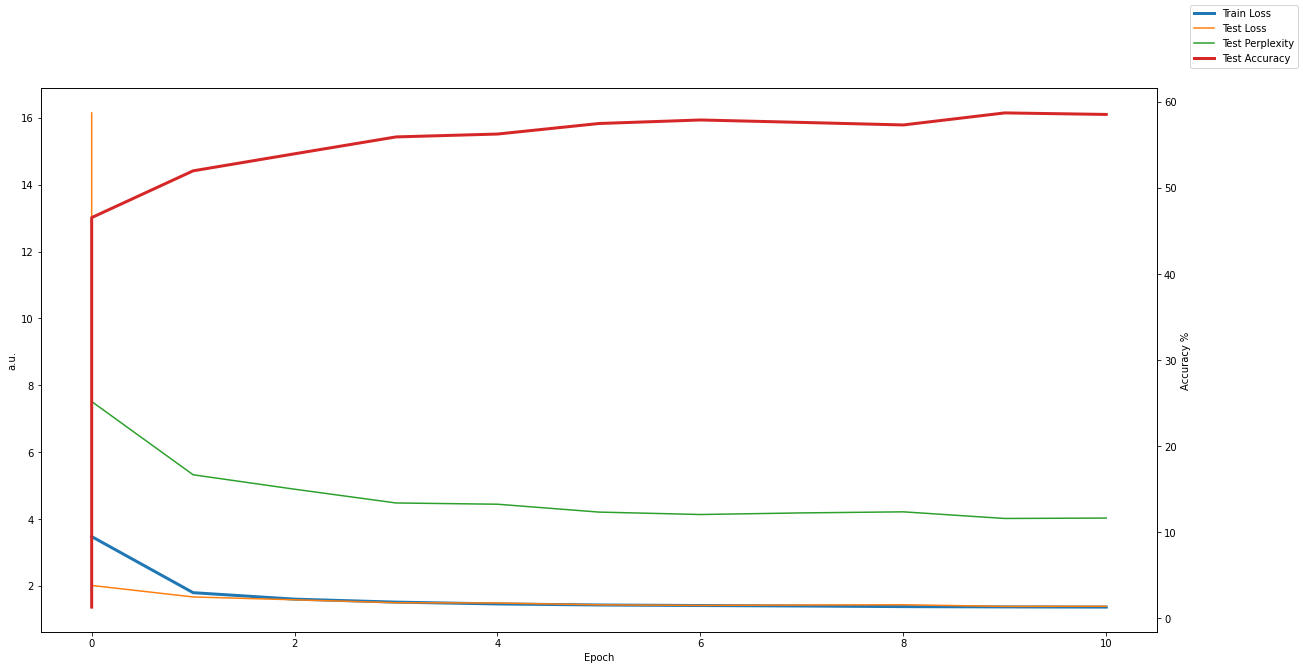

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 10
    LEARNING_RATE = 0.002
    # LEARNING_RATE = 0.01
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/HP_chars/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/HP_chars')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test_chars(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test_chars(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # add perplexity
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/HP_chars/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam')
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam', beam_width = 20)
            print('generated beam\t\t', generated_sentence)
            print('\n\n')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/HP_chars/%03d.pt' % epoch, 0)
        fig, ax1 = plt.subplots(figsize=(20,10))
        ep, val = zip(*train_losses)
        ln1 = ax1.plot(ep, val, label='Train Loss', linewidth=3)
        ep, val = zip(*test_losses)
        ln2 = ax1.plot(ep, val, label='Test Loss')
        ep, val = zip(*test_perplexities)
        ln3 = ax1.plot(ep, val, label='Test Perplexity')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('a.u.')
        ax2 = ax1.twinx()
        ep, val = zip(*test_accuracies)
        ln4 = ax2.plot(ep, val, label='Test Accuracy', linewidth=3, color='tab:red')
        ax2.set_ylabel('Accuracy %')
        fig.legend()
        return model, vocab, device

final_hp_char_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'max', temperature=1)
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'sample', temperature=(ii+1)*2/10)
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'beam', temperature=(ii+1)*2/10)
        print('generated with beam\t', generated_sentence)

vocab = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', 100, 512).vocab
eval_final_model(final_hp_char_model, vocab, device)

generated with max	 Harry Potter and the second of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs of the centaurs 
generated with sample	 Harry Potter and the chair of the centaurs in the centaurs around the second flew of the centaurs in the centaur at the end of the stairs, and started to her behind her behind her eyes of the stairs of the centart of the
generated with sample	 Harry Potter and the letter single so silence in the dementors of the centrance as the end of the class of the slightly and Hermione were the repeated the wall of the end of the back of the bed of the destrate her eyes o
generated with sample	 Harry Potter and them watched the only of the person close less of Snape said the spider to the staff the people let out of the window. "She what are the wizards someone still he would have to be the other the mead, but 
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# 1. Train a char predictor on a different text corpus, The King James Version of the Bible

1. What corpus did you choose? How many characters were in it?

I chose the KJV Bible. I figured it'd be easy to find on the web and it was. Also I though the old English style might generate some interesting and fun results by stringing words together in ways that are unconventional today. Finally, what I was really hoping for was for it to generate chapter/verse numbers in there to create some non-canon Bible verses.

It had 84 unique chars which included numbers and special chars such as : for chapter verse notations. It also picked up tokens like \[ and \] which likely were in some header or footer.

2. What differences did you notice between the sentences generated with the new/vs old corpus.

There isn't a significant difference between the two bodies of text and they tend to repeat themselves (with greedy and beam search methods). This is to be expected to a certain extent, there's a high likelihood of encountering the word 'the' or similar phrases anywhere in the English language.

One thing I did was sweep temperature for beam search and uniform sampling from 0.2 to 2 for both HP and KJV. The KJV beam search tended to produce a wider variety of outputs across the beam search algorithm temperature sweep. That is to say that the HP beam search tended to have a higher repetition. Thinking about it, maybe this is due to a difference in unique word count. The number of chars for each set is about the same (~80ish) but the unique word count may be different. This would mean that a letter in the KJV bible (e.g. 'a') would have more options for following chars and so a wider distributed output.

One thing that was different is that I get more overfitting of the Bible than I did Harry Potter. Training loss was about 1.2, but testing loss was consistently about 1.6. I think this is because the Bible training set vocabulary is much smaller than the HP training set (8.8M total chars for the Bible vs 12.7M for HP)

3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

Seed:
>Let there be light. 

Max: 
>Let there be light. 11:1 And the servant shall be a seep a good to the congregation of the children of Israel, and the s


Sample (T=0.4):
>Let there be light. And the king of the LORD speak the seed of the LORD hath spoiled against the congregation of the con



Beam (T = 2):
>Let there be light. And they shall come unto the people, that they shall not bear the people of the earth, and they shall


I played around with temp for beam a lot. It gets stuck in the 'the' loop so I was hoping that by jacking up temp it'd diffuse the probabilities out to less likely options. But now that I think about it increasing the temp flattens the curve but is order preserving. It won't really change the top k values so actually this is very unlikely to make a difference.





In [81]:
# Prepare KJV Bible data
print('Preparing KJV data')
prepare_data(DATA_PATH + 'KJV_Bible.txt')
print('Done')

print('Preparing Reversed KJV data')
prepare_data(DATA_PATH + 'KJV_Bible.txt', chars=True, reverse=True)
print('Done\n')

print('Preparing Reversed KJV word data')
prepare_data(DATA_PATH + 'KJV_Bible.txt', chars=False, reverse=True)
print('Done\n')

data = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_train.pkl', 100, 256)
vocab = data.vocab
print('KJV has {} unique tokens'.format(len(vocab)))
print([k for k, v in vocab.voc2ind.items()])
print('KJV has {} total chars'.format(len(data)*256))

Preparing KJV data
Sanity check:	 ﻿The Project Gutenberg EBook of The King James Bible ***********************************************
Write file
Write file
Done
Preparing Reversed KJV data
Sanity check:	 .skooBe wen tuoba raeh ot rettelswen liame ruo ot ebircsbus ot woh dna ,skooBe wen ruo ecudorp pleh 
Write file
Write file
Done

Preparing Reversed KJV word data
Sanity check:	 ['eBooks.', 'new', 'about', 'hear', 'to', 'newsletter', 'email', 'our', 'to', 'subscribe', 'to', 'how', 'and', 'eBooks,', 'new', 'our', 'produce', 'help', 'to', 'how', 'Foundation,', 'Archive', 'Literary', 'Gutenberg', 'Project', 'the', 'to', 'donations', 'make', 'to', 'how', 'including', 'Gutenberg-tm,', 'Project', 'about', 'information', 'includes', 'site', 'Web', 'This', 'http://www.gutenberg.org', 'facility:', 'search', 'PG', 'main', 'the', 'has', 'which', 'site', 'Web', 'our', 'at', 'start', 'people', 'Most', 'edition.', 'paper', 'particular', 'any', 'with', 'compliance', 'in', 'eBooks', 'keep', 'necessari

Using device cuda
num workers: 2
Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	oE$dtD$   7$DDw7Td6@wy7eZ  6cE$deF $Dt$t$$$?wtb﻿$$1#bddTt$t@$$EDtDu$ Cdm@93$ wtdi﻿$d6NFt@$$NNQpp32Yf


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	$ wfidodQ6$eupNgg66w$m@$$Ttwc77"gu   g TtFF$ wfidudLpz﻿$D6tFtb3p$T4%Wt$d6tFNZCCCd6NFt@$$FNpNguu wfid


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	$$Fe!!DNdCCC?EE7$6$$$L9pTgg1QFow!!﻿$ELL eset$s66w$m@$!﻿$Dp6$seFFeeuF 9ptLd66w$m@$$ m@$t$ sbNpdP gggd




  0%|          | 0/135 [00:00<?, ?it/s]

Input	 man with an unclean spirit, 5:3 Who had his dwelling among the tombs; and no man could bind him, no
GT	man with an unclean spirit, 5:3 Who had his dwelling among the tombs; and no man could bind him, no,
pred	F!d6F1smt$d6Fs6Q44DQ$e$sbs3R$G ggLWw  dNC@s3$Ngggd94%dddw7TdT@$$mw!LLuLD6tFTw$dd6FQwcfid%%%%$$s!%$6w



Test set: Average loss: 15.1785, Accuracy: 14652/844800 (2%)



  2%|▏         | 3/135 [00:00<00:18,  7.09it/s]

Train Epoch: 0 [0/34560 (0%)]	Loss: 15.283622


 76%|███████▋  | 103/135 [00:09<00:02, 11.29it/s]

Train Epoch: 0 [25600/34560 (74%)]	Loss: 1.699345


100%|██████████| 135/135 [00:11<00:00, 11.29it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	oitre thne obong theue   ahcritr ti rtthe Lerd  a:16 And the Lore  tf thes perdy  and the paaitr ily


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	euld tott aae  tt   the Lreutd  a:1  And theuld thast  and tege toght tbd toy  and the phe  thalld t


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 thye toy  aher the exer ths sore  ai thydh tnto the , tOt tp aisseafer tnto the Lfher ihn   1:11 An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the the LORD that the LORD that the LORD that the LORD God of the LORD that the LORD that the LORD that the LORD that the LORD that the LORD that the LORD that the LORD that the LORD that the LORD 





  1%|▏         | 2/135 [00:00<00:24,  5.42it/s]

Train Epoch: 1 [0/34560 (0%)]	Loss: 1.793282


 76%|███████▌  | 102/135 [00:09<00:03, 10.88it/s]

Train Epoch: 1 [25600/34560 (74%)]	Loss: 1.630326


100%|██████████| 135/135 [00:12<00:00, 10.89it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	oitre ttn  tnong theuee  ahcc tr ta ttthe Lirds a:16 And the Lomrttof thes tirdo  and the sasott ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld oomt tttt tt o the toound  a:1  And ttauld ttett  and tegtdtoght ald ooy  and the sott ttauld o


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 stie toy  ahen the saer tis tomet ae styth tnto the   aOt tp toytotfer tnto the Luher ttno  111  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the son of the LORD of the son of the LORD of the son of the LORD of the son of the LORD of the son of the LORD of the son of the LORD of the son of the LORD of the son of the LORD of the son of th





  1%|▏         | 2/135 [00:00<00:25,  5.13it/s]

Train Epoch: 2 [0/34560 (0%)]	Loss: 1.491218


 76%|███████▌  | 102/135 [00:09<00:02, 11.17it/s]

Train Epoch: 2 [25600/34560 (74%)]	Loss: 1.498808


100%|██████████| 135/135 [00:12<00:00, 10.97it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre tinn along theuee  ahch tr te rtthe Lards a:16 And the Lhmr  of thes iirdy, and theywasoiveul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auldebolt iied tt o the haound  a:11 And teeuld teeep  and tegeduoght hld wey  and the coep ohauld o


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Loie ooy  ahin the haer ois aome  ae soidh tnto the , tOt tp telseofer tnto the Lfher iine  111  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the house of the LORD of the house of the LORD of the house of the LORD of the house of the LORD of the house of the LORD of the house of the LORD of the house of the LORD of the house of the LORD 





  1%|▏         | 2/135 [00:00<00:24,  5.40it/s]

Train Epoch: 3 [0/34560 (0%)]	Loss: 1.378925


 76%|███████▌  | 102/135 [00:09<00:02, 11.25it/s]

Train Epoch: 3 [25600/34560 (74%)]	Loss: 1.332108


100%|██████████| 135/135 [00:12<00:00, 11.23it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre ttnn anong theuee  thch tr te rtthe Lards t:16 And the Lhmr tof thes tirds, tnd the caariv ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld tomt tttt tt o the laound  t:1  And tteuld thewp  and tegt toght ind tey  and the ctnn thauld t


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Ltie toy  ahen the Laen tis tome  ae wtith tnto the , tOt tn tersetfer tnto the Luher ihne  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of the c





  2%|▏         | 3/135 [00:00<00:22,  5.78it/s]

Train Epoch: 4 [0/34560 (0%)]	Loss: 1.313288


 76%|███████▋  | 103/135 [00:09<00:02, 11.45it/s]

Train Epoch: 4 [25600/34560 (74%)]	Loss: 1.291532


100%|██████████| 135/135 [00:11<00:00, 11.27it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre tenn olong theune  ahch tr te rtthe sirds t:14 And the Lhmrt of thes hirds, tnd she sasrit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bolt iett tn o the laaund  a:1  And taauld seewp  and tege uoght ild tiy  and she soap ohauld s


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Laie tay  ahin the taen tis nomet ae saidh tnto the , tOt tn trrseover tnto the Lther tine  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. 4:11 And the LORD said unto the LORD thy God of the children of the children of the children of the children of the children of the children of the children of the children of the children of the child





  1%|▏         | 2/135 [00:00<00:24,  5.34it/s]

Train Epoch: 5 [0/34560 (0%)]	Loss: 1.272603


 76%|███████▌  | 102/135 [00:09<00:02, 11.09it/s]

Train Epoch: 5 [25600/34560 (74%)]	Loss: 1.340315


100%|██████████| 135/135 [00:12<00:00, 10.97it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	h tre tenn onong theune, ahch an te rdthe pird  a:1  And the Lhmr  of thes hirdd, and the paariteul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld nomt ihtd tn o the laaund  a:1  And taeuld nhewp  and tege uoght and teys and the porp ohauld n


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Loie tay  ahen the Lair ois nome  ae saidh tnto the , aOt tp trrs,over tnto the Lther ahne  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the priests of the children of the children of Israel, and the princes of the children of the children of the children of the children of Israel, and the princes of the children of the children of 





  1%|▏         | 2/135 [00:00<00:24,  5.43it/s]

Train Epoch: 6 [0/34560 (0%)]	Loss: 1.230199


 76%|███████▌  | 102/135 [00:09<00:02, 11.26it/s]

Train Epoch: 6 [25600/34560 (74%)]	Loss: 1.226955


100%|██████████| 135/135 [00:12<00:00, 11.03it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	h tre tonn olong theuns  ahch ar te rdthe pird  a:12 And the Lhmr  of thes pirdd  and the caarit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt ihtd tn o the caound  a:1  And taauld nhewp  and tege uoght igd teys and the coc  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Loie tay  ahin the Lain ois nome  ae saidh tnto the , aOt tp trrseover tnto the Lther oine  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of the children of Israe





  1%|▏         | 2/135 [00:00<00:23,  5.55it/s]

Train Epoch: 7 [0/34560 (0%)]	Loss: 1.214138


 76%|███████▌  | 102/135 [00:09<00:02, 11.26it/s]

Train Epoch: 7 [25600/34560 (74%)]	Loss: 1.213986


100%|██████████| 135/135 [00:12<00:00, 11.13it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	aetre tenn olong theune  ahch as te rdthe pird  a:12 And the Lhmr  of thes pirdd  tnd the caaeiteul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt ihtd an o the caound  a:1  And theuld nhewp  and tege uoght agd toys and the coa  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 Loie tay  ahen the Laen ois aome  ae saidh tnto the , tOt tp arrseover tnto the Lther oine  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the children of Israel, and the children of Israel, and the children of Israel, and the children of Israel, and the children of Israel, and the children of Israel, and the children of Israel, and t





  2%|▏         | 3/135 [00:00<00:25,  5.26it/s]

Train Epoch: 8 [0/34560 (0%)]	Loss: 1.206334


 76%|███████▋  | 103/135 [00:09<00:02, 11.31it/s]

Train Epoch: 8 [25600/34560 (74%)]	Loss: 1.202724


100%|██████████| 135/135 [00:12<00:00, 11.15it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre tonn obong theuns  aoch ts te rdthe sird  a:1  And the shmr  of thes pirdd  and the sasrit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt oitd hn o the hoound  a:1  And thauld shewp  and sege uoght igd try  and she sor  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 soie tay  ahin the Lain ois oome  ae shidh tnto the , aOt ts uers over tnto the Lnher hide  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the sons of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son of Jerusalem the son





  1%|▏         | 2/135 [00:00<00:24,  5.42it/s]

Train Epoch: 9 [0/34560 (0%)]	Loss: 1.219459


 76%|███████▌  | 102/135 [00:09<00:02, 11.29it/s]

Train Epoch: 9 [25600/34560 (74%)]	Loss: 1.189836


100%|██████████| 135/135 [00:12<00:00, 11.09it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre tenn obong theuns  ahch as te rdthe sard  a:1  And the shmr  of thes pardd  and she saarit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt ieed an o the haound  a:1  And theuld seewp  and sege uoght igd sey  and she see  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 soie aay  ahin the Laen oas name  ae shidh tnto the , aet ts aesseover tnto the Lnher sede  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the sons of Jerusalem the son of Jerusalem, and said unto the LORD, and the children of Israel, and said unto him, and said unto him, and said unto him, and said unto him, and said unto the LORD, a





  1%|▏         | 2/135 [00:00<00:24,  5.51it/s]

Train Epoch: 10 [0/34560 (0%)]	Loss: 1.190218


 76%|███████▌  | 102/135 [00:09<00:02, 11.08it/s]

Train Epoch: 10 [25600/34560 (74%)]	Loss: 1.189087


100%|██████████| 135/135 [00:12<00:00, 11.08it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetre tenn ofong theuns  ahch as te rdthe sord  a:1  And the shmr  of thes pardd  and the sasrit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt itt  an o the laound  a:1  And theuld beewp  and tege uoght agd tiy  and she ser  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 soie tay  ahen the Laen oas nome  ae shidh tnto the , aOt ts arsseover tnto the Lnher side  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the sons of Jerusalem the son of Jerusalem the son of Jerusalem, and said unto the LORD, and the children of Israel, and said unto the LORD, and the children of Israel, and said unto the LORD, and 





  1%|▏         | 2/135 [00:00<00:24,  5.37it/s]

Train Epoch: 11 [0/34560 (0%)]	Loss: 1.168922


 76%|███████▌  | 102/135 [00:09<00:02, 11.34it/s]

Train Epoch: 11 [25600/34560 (74%)]	Loss: 1.178129


100%|██████████| 135/135 [00:12<00:00, 11.11it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetse tonn ofong theuns  aoch as te rdthe sord  a:1  And the shmr  of thes pardd  and the saarit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt itt  an o the loound  a:1  And theuld beewp  and tege uoght agd tiy  and the ser  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 sone tay  ahen the Lain oas tome  ae shidh tnto the , aet ts nrsseover tnto the Lnher side  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 The Father, the Son, and the Holy Spirit walk into a bar. And the sons of Jerusalem the son of Jerusalem, and the sons of the children of Israel, and the sons of the children of Israel, and said unto the LORD, and the children of Israel, and said unto the LOR





  1%|▏         | 2/135 [00:00<00:24,  5.38it/s]

Train Epoch: 12 [0/34560 (0%)]	Loss: 1.163963


 76%|███████▌  | 102/135 [00:09<00:02, 11.39it/s]

Train Epoch: 12 [25600/34560 (74%)]	Loss: 1.169802


100%|██████████| 135/135 [00:12<00:00, 11.12it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetse tenn ofong theuns  aoch as te rdthe sord  a 1  And the shmr  of thes perdd  and the seaeit ul 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	auld bomt iee  on o the loeund  a:1  And teeuld beewp  and tege uoght agd tey  and the see  ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 seie tay  ahen the Laen oes tome  ae seidh tnto the , Tet ts nesseiver tnto the Lnher sede  1:1  An


Input	 man with an unclean spirit, 5:3 Who 

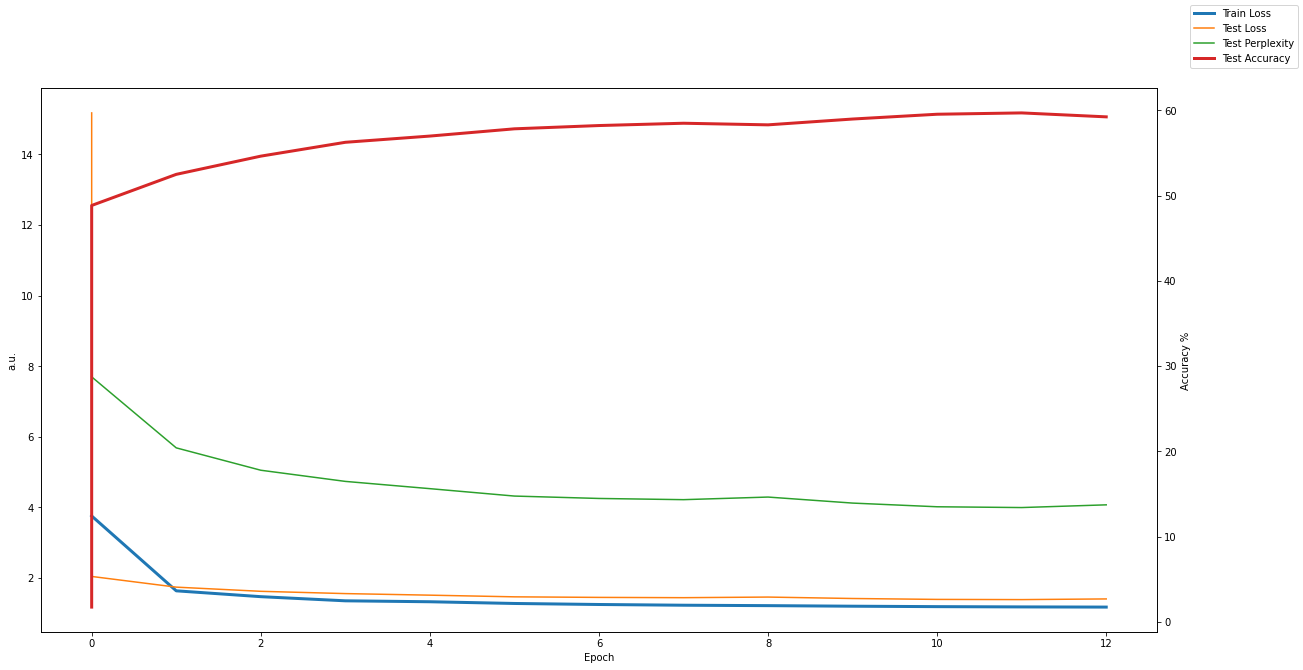

In [ ]:

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 12
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 100
    LOG_PATH = DATA_PATH + 'logs/KJV/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/KJV')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test_chars(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test_chars(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # add perplexity
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/KJV/%03d.pt' % epoch)
            seed_words = 'The Father, the Son, and the Holy Spirit walk into a bar. '
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam')
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam', beam_width = 20)
            print('generated beam\t\t', generated_sentence)
            print('\n\n')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/KJV/%03d.pt' % epoch, 0)
        fig, ax1 = plt.subplots(figsize=(20,10))
        ep, val = zip(*train_losses)
        ln1 = ax1.plot(ep, val, label='Train Loss', linewidth=3)
        ep, val = zip(*test_losses)
        ln2 = ax1.plot(ep, val, label='Test Loss')
        ep, val = zip(*test_perplexities)
        ln3 = ax1.plot(ep, val, label='Test Perplexity')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('a.u.')
        ax2 = ax1.twinx()
        ep, val = zip(*test_accuracies)
        ln4 = ax2.plot(ep, val, label='Test Accuracy', linewidth=3, color='tab:red')
        ax2.set_ylabel('Accuracy %')
        fig.legend()
        return model, vocab, device

final_kjv_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'God is good.'
    sequence_length = 200

    generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'max', temperature=1)
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'sample', temperature=(ii+1)*2/10)
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'beam', temperature=(ii+1)*2/10)
        print('generated with beam\t', generated_sentence)

vocab = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_test.pkl', 100, 512).vocab
eval_final_model(final_kjv_model, vocab, device)

generated with max	 God is good. 11:12 And the servant shall be a seep a good to the congregation of the children of Israel, and the seek of the LORD the LORD the LORD the LORD the LORD the LORD the LORD the LORD the LORD the LORD t
generated with sample	 God is good. 11:1 And the see of the seek of the LORD seek the LORD hath seen the seed of the LORD, and the seek of the LORD the son of Jerusalem, and the seep of the LORD the LORD the LORD the LORD the LORD the 
generated with sample	 God is good. 26:14 And the see of the LORD hath sent unto the LORD speak unto the LORD, the seep of the LORD the LORD shall be with thee. 12:20 And the sea seep all the people the seeketh the LORD of God when the
generated with sample	 God is good. 4:11 And he shall slew the trees of the counsel of the children of was for ever the beast of the lien for ever unto the king of the LORD thy gods were the field: 19:1 And the sent the people and the 
generated with sample	 God is good. 49:7 And they were they

# 3. Use an LSTM instead of a GRU

1. What new difficulties did you run into while training?

No real new difficulties. The training worked pretty well out of the box with the same hyperparameters as before. It took a bit to figure out how to handle all the different argument passing, but that was to be expected.

2. Were results better than the GRU? Provide training and testing plots.

Sadly results weren't better than the GRU network using a similar architecture. Both network ended up with ~60% accuracy, indicating that maybe this is a fundamental text limitation. I'm sure I could eek out some more accuracy and I could play around with the architecture a bit more to see if it is more sensitive, but ultimately this HW really should get turned in eventually :P It's already 2 days late at this point when I'm writing this.

3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

Seed:
> God is good.

Max:
>God is good. 11:14 And the servant of the LORD said unto the LORD, and the servant of the LORD shall be a strong and the service of the LORD shall be a strong and the service of the LORD shall be a strong and the

Sample (T=0.4):
>God is good. 15:12 And the children of Manoth, and the standish the servants of the villages of the priests of the service of the LORD the LORD thy God in the sword, and the armies of the children of Israel came 


Beam (T=1):
>God is good., and they shall come to pass, wherefore the LORD shall come to pass, wherefore the LORD shall not return in the midst of the children of Israel, and all the children of Israel, and all the children of



In [ ]:
TEMPERATURE = 0.5

class HarryPotterNetLSTM(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNetLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm    = nn.LSTM(input_size=self.feature_size, hidden_size=self.feature_size, batch_first=True)
        # self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidcell=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        # x, hidden_state = self.gru(x)
        x, hidcell = self.lstm(x, hidcell)
        x = self.decoder(x)
        
        return x, hidcell

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidcell=None, temperature=1):
        x = x.view(-1, 1)
        x, hidcell = self.forward(x, hidcell)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidcell

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([85, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([85, 512]) = 0MB
decoder.bias -> 	torch.Size([85]) = 0MB

Restored all variables
No new variables
Restored content/checkpoints/KJV_LSTM/012.pt
Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetne tel  anong theuns, aoch as ae rdthe Lord  a:14 And the Lhpc  of thes dirdd  and the peseit  l 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	eu d to

  0%|          | 0/135 [00:00<?, ?it/s]

Input	 man with an unclean spirit, 5:3 Who had his dwelling among the tombs; and no man could bind him, no
GT	man with an unclean spirit, 5:3 Who had his dwelling among the tombs; and no man could bind him, no,
pred	tan ahth t  hndlean sherit  a:1 Ahe hat tes seelting inong the crnera and totman aamnd tetd tis  aer



Test set: Average loss: 1.3975, Accuracy: 501622/844800 (59%)



  2%|▏         | 3/135 [00:00<00:22,  5.94it/s]

Train Epoch: 12 [0/34560 (0%)]	Loss: 1.158642


 76%|███████▌  | 102/135 [00:10<00:03, 10.17it/s]

Train Epoch: 12 [25600/34560 (74%)]	Loss: 1.161673


100%|██████████| 135/135 [00:13<00:00, 10.14it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	het e tel  anong theuns  aorh as te rtthe Lord  a:1  And the Lhmc  of thes tardd  and the ceaeit  l 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	eu d tout ttt  tn o the hround  a:1  And theuld beewp  and tege uoght ind tiy  and the perd ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 thie toy  ahen the Lain tas tome  ae shidh tnto the , Tet ts aoss tfer tnto the Lther side, 1:1  An


Input	 man with an unclean spirit, 5:3 Who 

  0%|          | 0/135 [00:00<?, ?it/s]

generated sample	 The Father, the Son, and the Holy Spirit walk into a bar. 3:22 And as a children of Essera the son of Heriah, and the flesh in the captain of the time that were a rise in the land of the thing that have committed them the word of the LORD: and they are his s
generated sample	 The Father, the Son, and the Holy Spirit walk into a bar. 3:11 And the sons of Ashraim with the son of Jerusalem. 1:19 And the LORD said unto them, And the LORD spake unto the LORD of Israel. 3:1 And the tribe of the LORD said unto him, Where it shall be no 





  2%|▏         | 3/135 [00:00<00:23,  5.69it/s]

Train Epoch: 13 [0/34560 (0%)]	Loss: 1.160034


 76%|███████▋  | 103/135 [00:10<00:03, 10.08it/s]

Train Epoch: 13 [25600/34560 (74%)]	Loss: 1.168111


100%|██████████| 135/135 [00:13<00:00, 10.00it/s]


Input	ch are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitful
GT	h are sown among thorns; such as hear the word, 4:19 And the cares of this world, and the deceitfuln
pred	hetse teln anong theuns  aoch as ae rtthe sards a:14 And the shmc  of thes sardd  and the seseit  l 


Input	hould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should 
GT	ould cast seed into the ground; 4:27 And should sleep, and rise night and day, and the seed should s
pred	eusd aaut tttn an o the lround  a:14 And theuld beewp  and tege uoght ind tiys and the serd ohauld b


Input	e same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 A
GT	 same day, when the even was come, he saith unto them, Let us pass over unto the other side. 4:36 An
pred	 shie tays ahen the Lain tas tome  ae shidh tnto the , Tet ts arss ofer tnto the Lther side, 1:1  An


Input	 man with an unclean spirit, 5:3 Who 

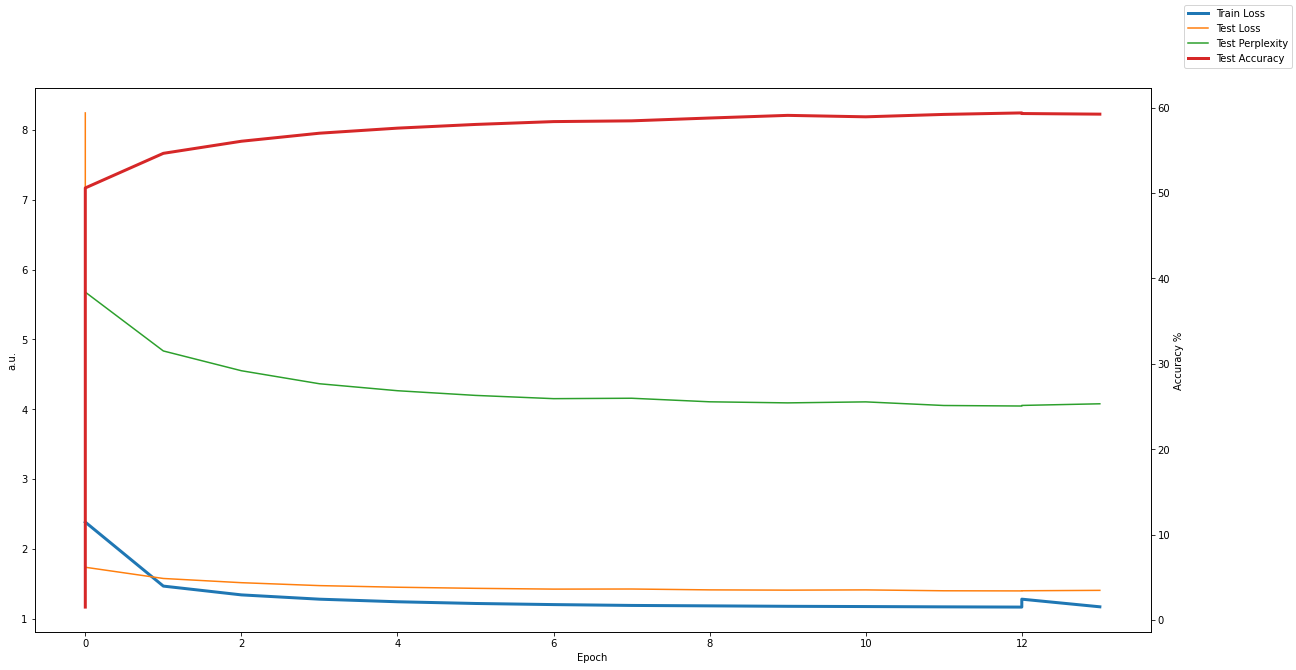

In [66]:

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 13
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 100
    LOG_PATH = DATA_PATH + 'logs/KJV_LSTM/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetLSTM(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/KJV_LSTM')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test_chars_lstm(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train_lstm(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test_chars_lstm(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # add perplexity
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/KJV_LSTM/%03d.pt' % epoch)
            seed_words = 'The Father, the Son, and the Holy Spirit walk into a bar. '
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'lstm-sample')
                print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam')
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam', beam_width = 20)
            # print('generated beam\t\t', generated_sentence)
            print('\n\n')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/KJV_LSTM/%03d.pt' % epoch, 0)
        fig, ax1 = plt.subplots(figsize=(20,10))
        ep, val = zip(*train_losses)
        ln1 = ax1.plot(ep, val, label='Train Loss', linewidth=3)
        ep, val = zip(*test_losses)
        ln2 = ax1.plot(ep, val, label='Test Loss')
        ep, val = zip(*test_perplexities)
        ln3 = ax1.plot(ep, val, label='Test Perplexity')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('a.u.')
        ax2 = ax1.twinx()
        ep, val = zip(*test_accuracies)
        ln4 = ax2.plot(ep, val, label='Test Accuracy', linewidth=3, color='tab:red')
        ax2.set_ylabel('Accuracy %')
        fig.legend()
        return model, vocab, device

final_kjv_lstm_model, vocab, device = main()

In [71]:
def eval_final_model(model, vocab, device):
    seed_words = 'God is good.'
    sequence_length = 200

    generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'max', temperature=1)
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'sample', temperature=(ii+1)*2/10)
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'beam', temperature=(ii+1)*2/10)
        print('generated with beam\t', generated_sentence)

vocab = HarryPotterDataset(DATA_PATH + 'KJV_Bible_chars_test.pkl', 100, 512).vocab
eval_final_model(final_kjv_lstm_model, vocab, device)

generated with max	 God is good. 11:14 And the servant of the LORD said unto the LORD, and the servant of the LORD shall be a strong and the service of the LORD shall be a strong and the service of the LORD shall be a strong and the
generated with sample	 God is good. 11:2 And the LORD said unto the LORD God of his servants and thy servants shall be a strong and the servant of the LORD shall be a strong and thy servants and the seven and the children of Israel wit
generated with sample	 God is good. 15:12 And the children of Manoth, and the standish the servants of the villages of the priests of the service of the LORD the LORD thy God in the sword, and the armies of the children of Israel came 
generated with sample	 God is good. 2:13 And it be griven of the like of the LORD our houses, and thy service of the seventh men where they brought the service of the service of all things sheight be causeth, and will dwell the writtin
generated with sample	 God is good. <UNK>4:3 Then said, Phu

# 6. Train a model on words instead of chars

1. What new difficulties did you run into while training?

Besides the fact that I had to rewrite some of the components to make them compatible with full words instead of chars, I am having difficult getting my model accuracy above ~15%. Other than that I haven't encountered too many difficulties. The vocabulary parsing was straight forward and there was some fun mods regarding missing keys in dicts, but the logistics were fine.

2. How large was your vocabulary?

~ 12000 unique words. This is paring down from ~60000 words that the book actually has based on the recommendation of removing words with fewer than 5 occurences in the text from the vocabulary.

3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you

I trained for 10 epochs using the same settings as before for chars. Using this question as a hint, I modified the sequence length first, doubling it to 200. The thought was that because the vocab is much, much larger than the char vocab that the model might need to see more units in a row to get a better feel for the words. Before we had ~30 unique chars and sequence length of 100, now we've got ~10000 unique words and only 200 sequence length. I imagine that having the sequence length be an order of magnitude larger than the vocab size might be useful so that there's a high chance of getting non-correlated data in the sequence.

Next I increased batch size from 256->512. I didn't expect this to make a difference. If I understand this correctly, this just helps the SGD move faster since we've got more data points. In an epoch, we'll eventually use all the data so a batch size increase means we chug through those data points faster, but eventually we'll get all the same gradient information (I think).

Next I double the feature size of the network. If I can't load more data in a sequence, maybe I can just extract more features out of that data. Of course this makes all previous weights for a 512 sized network useless so the training essentially begins again. That's OK because it only take ~10 epochs to stabilize for the standard settings. I ran this new larger network for 10 epochs and it seems to have stabilized at around the same accuracy as the smaller network. This seems to indicate we have insufficient data since we can't extract deeper features using the same style of network.


What I find most interesting is that even though the words model and chars models are both at the same *technical* accuracy, the words model *feels* more accurate. I think this is because my brain can piece together a series of incoherent words a lot better than a series of incoherent letters. I think there's something to be exploited here. We don't have to have perfect AI to have good results when our wetware can fill in the gaps for the AI. But that's just my humble opinion...

**Generated**

\<UNK\> is the filler for the words I eliminated from the vocab because the occured too infrequently

Seed:
> Harry raised his wand

Max:
>Harry raised his wand and Hermione had been \<UNK\> I think we'll have been \<UNK\> I think we'll have been \<UNK\> I think we'll have been \<UNK\> I think we'll have been \<UNK\>

Sample (T=0.2):
> Harry raised his wand at the Dark Lord Voldemort. Chamber Secrets firm grip on the grimly, and then <UNK> argue fight. map and Ginny and Ron looked up. <UNK> I think we'll have been <UNK> cat, afternoon. visitors bike screamed. here? continued, <UNK> as though were <UNK> you!" altogether <UNK> He knew he said. <UNK> I want to find the sloped <UNK> jus' <UNK> I expect twitched and Hermione whispered. Harry told him back. It was almost <UNK> doorstep <UNK> but he said. <UNK> He looked around. cracking noise came to the Dark Lord Voldemort's <UNK> I think it was looking at the castle

Beam (T=1):
> Harry raised his wand pointing at Hogwarts School Witchcraft his eyes fixed upon the Dark Lord Voldemort would make sure enough, he could have been trying to make sure enough...

12593
Using device cuda
num workers: 2
Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had 

  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 36.0483, Accuracy: 22/204800 (0%)



  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 0 [0/8704 (0%)]	Loss: 35.900890


 32%|███▏      | 11/34 [00:10<00:22,  1.02it/s]

Train Epoch: 0 [2560/8704 (29%)]	Loss: 27.328274


 62%|██████▏   | 21/34 [00:20<00:13,  1.01s/it]

Train Epoch: 0 [5120/8704 (59%)]	Loss: 18.047705


 91%|█████████ | 31/34 [00:30<00:02,  1.00it/s]

Train Epoch: 0 [7680/8704 (88%)]	Loss: 13.977847


100%|██████████| 34/34 [00:33<00:00,  1.01it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. few saw the stay. DO terrible terrible terrible terrible boiling "Loads Prince's <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 1 [0/8704 (0%)]	Loss: 12.429037


 32%|███▏      | 11/34 [00:10<00:21,  1.06it/s]

Train Epoch: 1 [2560/8704 (29%)]	Loss: 10.517240


 62%|██████▏   | 21/34 [00:19<00:12,  1.07it/s]

Train Epoch: 1 [5120/8704 (59%)]	Loss: 9.546247


 91%|█████████ | 31/34 [00:29<00:02,  1.05it/s]

Train Epoch: 1 [7680/8704 (88%)]	Loss: 8.829966


100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. mother mother mother mother ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ..." ... ... ... ..." ... ... ... ..." ... ... ... ..." ... ... ..." Wormtail. ... ... ..." Wormtail. ... ... ..." ... ... ... ..." 'is Wormtail. . . . . . . . . . . . . . . . . . . . . . ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ..." ... ... ... ... ... ..." ... ... ... ..." ... ... ... ..." ... ... ... ..." 'is ... ... ... ... ... ..." 'is ... ... ... ... ... ..." ... ... ... ..." 'is Wormtail. ... ... ... ... ..." ... ... ... ..." 'is Wormtail. haven't ... ... ... ... ... ..." ... ... ... ..." ... ... ..." 'is "Quite ... ... ... ... ... ... ... ..." ... ... ... ..." 'is Wormtail. ... ... ... ... ..." ... ... ... ... ..." 'is Wormtail. haven't ... ... ... ... ..." ... ... ... ..." ... ... ..." 'is "Quite ... ... ... ... ... ... ...





  3%|▎         | 1/34 [00:01<00:35,  1.09s/it]

Train Epoch: 2 [0/8704 (0%)]	Loss: 8.512495


 32%|███▏      | 11/34 [00:10<00:22,  1.01it/s]

Train Epoch: 2 [2560/8704 (29%)]	Loss: 8.113945


 62%|██████▏   | 21/34 [00:20<00:12,  1.02it/s]

Train Epoch: 2 [5120/8704 (59%)]	Loss: 7.903656


 91%|█████████ | 31/34 [00:30<00:02,  1.04it/s]

Train Epoch: 2 [7680/8704 (88%)]	Loss: 7.643883


100%|██████████| 34/34 [00:33<00:00,  1.02it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. <UNK> the -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- er -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- er -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- er -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- er -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- er -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 3 [0/8704 (0%)]	Loss: 7.467622


 32%|███▏      | 11/34 [00:10<00:21,  1.05it/s]

Train Epoch: 3 [2560/8704 (29%)]	Loss: 7.274057


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 3 [5120/8704 (59%)]	Loss: 7.343465


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 3 [7680/8704 (88%)]	Loss: 7.108318


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. mother and the few of the the back of the her her <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> 

  3%|▎         | 1/34 [00:01<00:35,  1.08s/it]

Train Epoch: 4 [0/8704 (0%)]	Loss: 6.975937


 32%|███▏      | 11/34 [00:10<00:22,  1.03it/s]

Train Epoch: 4 [2560/8704 (29%)]	Loss: 6.982949


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 4 [5120/8704 (59%)]	Loss: 6.939712


 91%|█████████ | 31/34 [00:30<00:02,  1.04it/s]

Train Epoch: 4 [7680/8704 (88%)]	Loss: 6.912485


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. mother and her <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

  3%|▎         | 1/34 [00:01<00:35,  1.06s/it]

Train Epoch: 5 [0/8704 (0%)]	Loss: 6.834290


 32%|███▏      | 11/34 [00:10<00:22,  1.05it/s]

Train Epoch: 5 [2560/8704 (29%)]	Loss: 6.591246


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 5 [5120/8704 (59%)]	Loss: 6.535599


 91%|█████████ | 31/34 [00:30<00:02,  1.04it/s]

Train Epoch: 5 [7680/8704 (88%)]	Loss: 6.440964


100%|██████████| 34/34 [00:32<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:35,  1.08s/it]

Train Epoch: 6 [0/8704 (0%)]	Loss: 6.373789


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 6 [2560/8704 (29%)]	Loss: 6.271726


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 6 [5120/8704 (59%)]	Loss: 6.277519


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 6 [7680/8704 (88%)]	Loss: 6.239033


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 7 [0/8704 (0%)]	Loss: 6.179147


 32%|███▏      | 11/34 [00:10<00:21,  1.06it/s]

Train Epoch: 7 [2560/8704 (29%)]	Loss: 6.075877


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 7 [5120/8704 (59%)]	Loss: 6.078857


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 7 [7680/8704 (88%)]	Loss: 6.018606


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- you -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:35,  1.06s/it]

Train Epoch: 8 [0/8704 (0%)]	Loss: 5.988050


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 8 [2560/8704 (29%)]	Loss: 5.963085


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 8 [5120/8704 (59%)]	Loss: 5.923469


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 8 [7680/8704 (88%)]	Loss: 5.869766


100%|██████████| 34/34 [00:32<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- you -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 9 [0/8704 (0%)]	Loss: 5.851023


 32%|███▏      | 11/34 [00:10<00:22,  1.03it/s]

Train Epoch: 9 [2560/8704 (29%)]	Loss: 5.786154


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 9 [5120/8704 (59%)]	Loss: 5.789120


 91%|█████████ | 31/34 [00:29<00:02,  1.02it/s]

Train Epoch: 9 [7680/8704 (88%)]	Loss: 5.752332


100%|██████████| 34/34 [00:32<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- you -- -- -- -- ?" -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 10 [0/8704 (0%)]	Loss: 5.737488


 32%|███▏      | 11/34 [00:10<00:22,  1.03it/s]

Train Epoch: 10 [2560/8704 (29%)]	Loss: 5.673584


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 10 [5120/8704 (59%)]	Loss: 5.673878


 91%|█████████ | 31/34 [00:30<00:02,  1.04it/s]

Train Epoch: 10 [7680/8704 (88%)]	Loss: 5.638755


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. -- you -- -- -- ?" -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --





  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 11 [0/8704 (0%)]	Loss: 5.635684


 32%|███▏      | 11/34 [00:10<00:22,  1.03it/s]

Train Epoch: 11 [2560/8704 (29%)]	Loss: 5.582451


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 11 [5120/8704 (59%)]	Loss: 5.580048


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 11 [7680/8704 (88%)]	Loss: 5.550075


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. in the middle of the crowd and the cool, of the crowd and the arm, had been <UNK> he had ever seen in the since he had been the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had had ever seen since he had had seen in the first time he had





  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 12 [0/8704 (0%)]	Loss: 5.650790


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 12 [2560/8704 (29%)]	Loss: 5.550858


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 12 [5120/8704 (59%)]	Loss: 5.527408


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 12 [7680/8704 (88%)]	Loss: 5.474213


100%|██████████| 34/34 [00:33<00:00,  1.02it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. in the <UNK> <UNK> said Dumbledore, <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> They were <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> 

  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 13 [0/8704 (0%)]	Loss: 5.479566


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 13 [2560/8704 (29%)]	Loss: 5.431925


 62%|██████▏   | 21/34 [00:20<00:12,  1.05it/s]

Train Epoch: 13 [5120/8704 (59%)]	Loss: 5.457831


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 13 [7680/8704 (88%)]	Loss: 5.447045


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK

  3%|▎         | 1/34 [00:01<00:35,  1.06s/it]

Train Epoch: 14 [0/8704 (0%)]	Loss: 5.459230


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 14 [2560/8704 (29%)]	Loss: 5.398739


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 14 [5120/8704 (59%)]	Loss: 5.379677


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 14 [7680/8704 (88%)]	Loss: 5.352602


100%|██████████| 34/34 [00:32<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Ron looked up at the top of the table and a few minutes later, they were all the way back to the door and the burst into the room. The moment they had reached the end of the corridor and they saw the Malfoy was the only person who was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of the doors and the room was the only person who was the only person who was the <UNK> in the front of t

  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 15 [0/8704 (0%)]	Loss: 5.409136


 32%|███▏      | 11/34 [00:10<00:21,  1.05it/s]

Train Epoch: 15 [2560/8704 (29%)]	Loss: 5.361990


 62%|██████▏   | 21/34 [00:20<00:12,  1.04it/s]

Train Epoch: 15 [5120/8704 (59%)]	Loss: 5.369012


 91%|█████████ | 31/34 [00:29<00:02,  1.03it/s]

Train Epoch: 15 [7680/8704 (88%)]	Loss: 5.316355


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. in the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> dragon <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> 

  3%|▎         | 1/34 [00:01<00:35,  1.06s/it]

Train Epoch: 16 [0/8704 (0%)]	Loss: 5.341197


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 16 [2560/8704 (29%)]	Loss: 5.316262


 62%|██████▏   | 21/34 [00:20<00:12,  1.02it/s]

Train Epoch: 16 [5120/8704 (59%)]	Loss: 5.305684


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 16 [7680/8704 (88%)]	Loss: 5.270730


100%|██████████| 34/34 [00:32<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. in the middle of the room. <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> efforts <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> dragon <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <U

  3%|▎         | 1/34 [00:01<00:34,  1.05s/it]

Train Epoch: 17 [0/8704 (0%)]	Loss: 5.297612


 32%|███▏      | 11/34 [00:10<00:22,  1.03it/s]

Train Epoch: 17 [2560/8704 (29%)]	Loss: 5.258048


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 17 [5120/8704 (59%)]	Loss: 5.509962


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 17 [7680/8704 (88%)]	Loss: 5.376626


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. of <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> dragon <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK

  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 18 [0/8704 (0%)]	Loss: 5.380737


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 18 [2560/8704 (29%)]	Loss: 5.257753


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 18 [5120/8704 (59%)]	Loss: 5.243837


 91%|█████████ | 31/34 [00:30<00:02,  1.04it/s]

Train Epoch: 18 [7680/8704 (88%)]	Loss: 5.207159


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. to <UNK> the <UNK> of the <UNK> <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind the <UNK> of the <UNK> <UNK> <UNK> <UNK> ." <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> said Harry, as the <UNK> of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the <UNK> Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the <UNK> Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the <UNK> Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the <UNK> Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the Magical <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> the <UNK> of the <UNK> Magical <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> Behind <UNK> t

  3%|▎         | 1/34 [00:01<00:35,  1.07s/it]

Train Epoch: 19 [0/8704 (0%)]	Loss: 5.243011


 32%|███▏      | 11/34 [00:10<00:22,  1.02it/s]

Train Epoch: 19 [2560/8704 (29%)]	Loss: 5.199270


 62%|██████▏   | 21/34 [00:20<00:12,  1.02it/s]

Train Epoch: 19 [5120/8704 (59%)]	Loss: 5.277340


 91%|█████████ | 31/34 [00:30<00:02,  1.03it/s]

Train Epoch: 19 [7680/8704 (88%)]	Loss: 5.299937


100%|██████████| 34/34 [00:33<00:00,  1.03it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

  0%|          | 0/34 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. to the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <

  3%|▎         | 1/34 [00:01<00:34,  1.06s/it]

Train Epoch: 20 [0/8704 (0%)]	Loss: 5.340589


 32%|███▏      | 11/34 [00:10<00:22,  1.04it/s]

Train Epoch: 20 [2560/8704 (29%)]	Loss: 5.264961


 62%|██████▏   | 21/34 [00:20<00:12,  1.03it/s]

Train Epoch: 20 [5120/8704 (59%)]	Loss: 5.235957


 91%|█████████ | 31/34 [00:29<00:02,  1.04it/s]

Train Epoch: 20 [7680/8704 (88%)]	Loss: 5.191415


100%|██████████| 34/34 [00:32<00:00,  1.04it/s]


Input	him more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his face, paler and <UNK> than ever in the distant light of a <UNK> <UNK> are you all
GT	more Inferi creeping towards him around the sides of <UNK> but he blinked and saw that <UNK> was <UNK> all was still, the darkness complete but for a few <UNK> and lit upper windows. 'We did it, <UNK> Harry whispered with <UNK> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNK> Dumbledore staggered against him. For a moment, Harry thought that his <UNK> Apparition had thrown Dumbledore <UNK> then he saw his

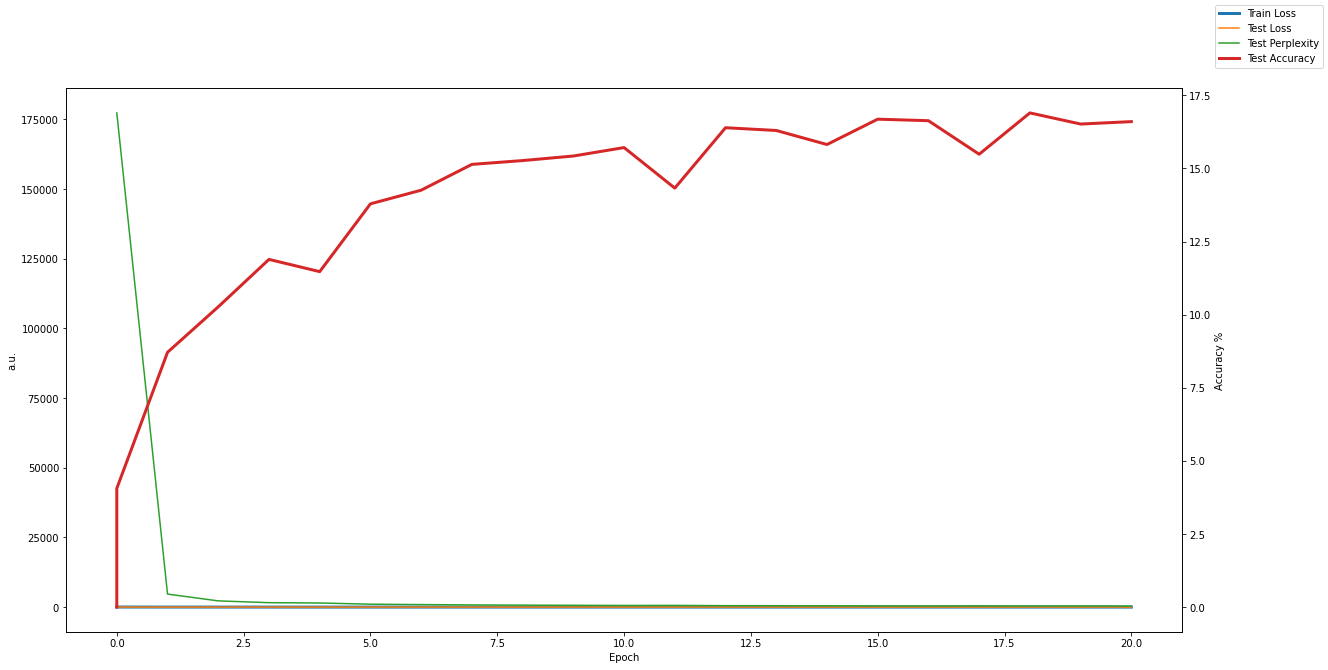

In [ ]:
# Test model on words

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    # FEATURE_SIZE = 512
    FEATURE_SIZE = 1024
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/HP_word/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab
    print(len(vocab))

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/HP_word')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test_words(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test_words(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # add perplexity
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/HP_word/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language_words(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language_words(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language_words(model, device, seed_words, 200, vocab, 'beam')
            # generated_sentence = generate_language_words(model, device, seed_words, 200, vocab, 'beam', beam_width = 20)
            print('generated beam\t\t', generated_sentence)
            print('\n\n')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/HP_word/%03d.pt' % epoch, 0)
        fig, ax1 = plt.subplots(figsize=(20,10))
        ep, val = zip(*train_losses)
        ln1 = ax1.plot(ep, val, label='Train Loss', linewidth=3)
        ep, val = zip(*test_losses)
        ln2 = ax1.plot(ep, val, label='Test Loss')
        ep, val = zip(*test_perplexities)
        ln3 = ax1.plot(ep, val, label='Test Perplexity')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('a.u.')
        ax2 = ax1.twinx()
        ep, val = zip(*test_accuracies)
        ln4 = ax2.plot(ep, val, label='Test Accuracy', linewidth=3, color='tab:red')
        ax2.set_ylabel('Accuracy %')
        fig.legend()
        return model, vocab, device

final_hp_word_model, vocab, device = main()

In [77]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry raised his wand '
    sequence_length = 100

    generated_sentence = generate_language_words(model, device, seed_words, sequence_length, vocab, 'max', temperature=1)
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_words(model, device, seed_words, sequence_length, vocab, 'sample', temperature=(ii+1)*2/10)
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language_words(model, device, seed_words, sequence_length, vocab, 'beam', temperature=(ii+1)*2/10)
        print('generated with beam\t', generated_sentence)

vocab = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', 100, 256).vocab
eval_final_model(final_hp_word_model, vocab, device)

generated with max	 Harry raised his wand and the flew out of the window. The door of the swung open and the door open. The door swung open and the door swung open and began to <UNK> his feet <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
generated with sample	 Harry raised his wand <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <

# BONUS: Reverse! Reverse!

I shared some of the silly made up Bible verses with a friend and he asked if I could run it in reverse. Instead of having to make up verses, what could I get if I tried to end a verse instead?

It was pretty easy to do since all it took was reversing the data when reading and saving it as a different file. The network just generates text in reverse then I flip it around to make it human readable at the output.

## Fun Findings:
I actually saw a few percentage point increase in the final accuracy for similar training compared to the "forward" prediction model. That's an interesting thing to see.

## Some fun sentences:

Seed:
>  and he saw that it was good.

1. >2:0 The spirits and goodness is than the world. 10:7 And they shall become me, and all terry: and he saw that it was good.
1. >the borders of the angels, and the daughters of Solomon, the daughters of the abominations; and he saw that it was good.


Second Seed:
> This is the way.

1. >Jesus answered, and entered into the house of God. 1:1 And it shall be delivered. 1:16 And Jesus answered, and said unto him. This is the way.
2. >the cities shall be delivered. 1:4 And he entered into the house of God, that I have delivered him in the treasures of the God, and he that day. This is the way.



Using device cuda
num workers: 2
Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	4e,Y,,aHETeY)eeoe4aeqtEQf0aT?sHHHTCswTskoTQw,P'uTskoCWs5w50,e,,,beww)z)Y,HaHY)H,,,,beww)z)5)jQ!KCbaD


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	,[s?sejT5e,,,,*)QQQ3,@wT,3,j)DwwYHKe<UNK>?T5w)jTQe,HPHDeDwojmHwd5QoY)ee,,ae’GHQHjT5e5WWHjT5wYjaQwm@wT,3,


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	bejT5e50o,?NTE:H5Go)jTf,,b3ejT5eYjaQwm@wT,3,))H,,PE﻿Qz<UNK><UNK>qT0TaHHQbejfHHHHCbaDQoY)ee,,ae’jAQQoY))wjEeE


  0%|          | 0/135 [00:00<?, ?it/s]

Input	c ruoy tel llahs ey nehT 22:4 ?senots eseht naem tahW ,gniyas ,emoc ot emit ni srehtaf rieht ksa lla
GT	 ruoy tel llahs ey nehT 22:4 ?senots eseht naem tahW ,gniyas ,emoc ot emit ni srehtaf rieht ksa llah
pred	weTCskw5Ete,,,baeE:8)jTseRR5,e5tE:DQ9wEPET:e)HjmH00b**,*xQS:PH,?UGwwwwwjmQ0o)Q,aTjT::rHT,?T:e<UNK>HHH,,,



Test set: Average loss: 8.4290, Accuracy: 19191/844800 (2%)



  2%|▏         | 3/135 [00:00<00:21,  6.05it/s]

Train Epoch: 0 [0/34560 (0%)]	Loss: 8.431579


 76%|███████▌  | 102/135 [00:10<00:03, 10.10it/s]

Train Epoch: 0 [25600/34560 (74%)]	Loss: 1.664057


100%|██████████| 135/135 [00:13<00:00, 10.14it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias ehtdna 1::2 .eeirpp eto heeoyeef eefedeotef eoht eaa fdih etnu dias ena ,dih etnu daem e hs J


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	iiep eht dla dnin r er ep eho  enh eeht dihw ,deep et emoc ea dea 112 .ead eht de diht dnrsr ur ep e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	tdht dahelarsI fo sohdlihc eht dnrsr ur ep ena ,denilo euuec eih eham e hs J fna 1:6 .tm t enac r eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 , and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said, and the said unto .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:27,  4.76it/s]

Train Epoch: 1 [0/34560 (0%)]	Loss: 1.593952


 76%|███████▌  | 102/135 [00:10<00:03, 10.15it/s]

Train Epoch: 1 [25600/34560 (74%)]	Loss: 1.468248


100%|██████████| 135/135 [00:13<00:00,  9.91it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dhtdna 8::2 .tentpt edon eeoyeef :ef,dr tef :oht taa ,deh otnu dias ena ,deh otnu dnew d hsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	i ep eht fla dnid doucric eho  enh eeht dihw ,drep ot emac ea dna 511 .tadaeht fa deht dnrsr ucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahelarsI fo eemdlihc eht fnrsr ucric ena ,deillo euue  eeh dham e hsoJ dna 8:6 .tm t enaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:27,  4.81it/s]

Train Epoch: 2 [0/34560 (0%)]	Loss: 1.423822


 76%|███████▌  | 102/135 [00:10<00:03,  9.81it/s]

Train Epoch: 2 [25600/34560 (74%)]	Loss: 1.380481


100%|██████████| 135/135 [00:13<00:00,  9.83it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 9::1 .tertpt ep a eeoydef de ,dr oef doht taa ,deh otnu dias ena ,seh otnu dnew d hsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht nla dnir roucric eho  enh eeht dehw ddrep ot emac ea dnA 711 .eadaeht fa deht oersa ucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo nerdlihc eht fnrsaoucric ena ,seilto euae  eeh dram e hsoJ dna 9:1 .em t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the children of God, and he said unto them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  2%|▏         | 3/135 [00:00<00:26,  4.94it/s]

Train Epoch: 3 [0/34560 (0%)]	Loss: 1.342794


 76%|███████▌  | 102/135 [00:10<00:03,  9.83it/s]

Train Epoch: 3 [25600/34560 (74%)]	Loss: 1.366786


100%|██████████| 135/135 [00:13<00:00,  9.81it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 9::1 .eerttt ev a euoydef def,dr oef doyt taa ,deh otnu dias dna ,seh otnu dnew d hsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht dla dnir roucric eho  enh eeht dehw ddrep ot emac ti dnA 5:1 .ead eht da deht oersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo derdlihc eht dnrsarucric ena ,seilto euah  eeh dram e hsoJ dnA 5:1 .em t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of God, and said unto them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:27,  4.79it/s]

Train Epoch: 4 [0/34560 (0%)]	Loss: 1.298814


 76%|███████▌  | 102/135 [00:10<00:03,  9.79it/s]

Train Epoch: 4 [25600/34560 (74%)]	Loss: 1.315519


100%|██████████| 135/135 [00:13<00:00,  9.75it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 9::1 .eerttsrevda euoyeef def,dr oef doyt taa ,deh otnu dias dna ,deh otnu dnew d hsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht fla dnirsroucric eho  enh eeht dehw ddsep ot emoc ti dnA 1:1 .eadaeht fb deht oersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo nerdlihc eht fnrsarucric ena ,sevlto euah  eeh dram e hsoJ dnA 5:1 .em t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 e of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the house of the priests: and they shall come to them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:28,  4.62it/s]

Train Epoch: 5 [0/34560 (0%)]	Loss: 1.268785


 76%|███████▌  | 102/135 [00:10<00:03,  9.83it/s]

Train Epoch: 5 [25600/34560 (74%)]	Loss: 1.294823


100%|██████████| 135/135 [00:13<00:00,  9.71it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 5::1 .serttsrevda euoydef def,dr oef doyt taa ,deh otnu dias dna ,deh otnu dnew d hsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht dla dnirsrrucric eho  enh eeht dehw dssep ot emac ti dnA 1:1 .eadaeht fb deht oersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo nerdlihc eht dnrsamucric ena ,deilto eueh  deh dram d hsoJ dnA 5:1 .em t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 : and they shall come out of the daughters of God, and said unto the house of God, and said unto the hand of the daughters of God, and said unto the house of God, and said unto them, and said unto them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:28,  4.68it/s]

Train Epoch: 6 [0/34560 (0%)]	Loss: 1.248370


 76%|███████▌  | 102/135 [00:10<00:03,  9.90it/s]

Train Epoch: 6 [25600/34560 (74%)]	Loss: 1.276412


100%|██████████| 135/135 [00:13<00:00,  9.68it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 5::1 .seittsrevda eeoyeef def,dr def doyt tsa ,deh otnu dias dna ,deh otnu dnew eihsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht dla dnirsrrucric eho  enh eeht dehw dssap ot emac ti dnA 5:1 .ead eht nb deht oersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo derdlihc eht dnrsamucric ena ,deilto eueh  deh dram d hsoJ dnA 5:1 .sm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		  came to the house of the daughters of the daughters of the daughters of the daughters of the daughters of the daughters of the daughters of the daughters of God, and said unto them, and said unto them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:29,  4.46it/s]

Train Epoch: 7 [0/34560 (0%)]	Loss: 1.239158


 76%|███████▌  | 102/135 [00:10<00:03,  9.75it/s]

Train Epoch: 7 [25600/34560 (74%)]	Loss: 1.256127


100%|██████████| 135/135 [00:14<00:00,  9.59it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 .dias dh dnA 5::1 .seittsrevda eioyeef def,dr def doyt tsa ,deh otnu dias dna ,dih otnu dnew eihsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a ep eht fla dnirsrrucric eho  enh eeht dehw ddsap ot emac ti dnA 5:1 .ead eht nb deht tersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo demdlihc eht dnrsarucric ena ,deilt  euah  aeh dram d hsoJ dnA 5:1 .sm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 d unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto them .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:26,  4.98it/s]

Train Epoch: 8 [0/34560 (0%)]	Loss: 1.230790


 76%|███████▌  | 102/135 [00:10<00:03,  9.69it/s]

Train Epoch: 8 [25600/34560 (74%)]	Loss: 1.245697


100%|██████████| 135/135 [00:14<00:00,  9.52it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA 5::1 .seirtsrevda eioyeef def,ds def doyt tsa ,deh otnu dias dna ,dih otnu dnew ehhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht fla dnirsrrocric eho  enh eeht dehw ddsap ot emac ti dnA 1:1 .dad eht nb deht tersarucric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo semdlihc eht dnrsarucric ena ,deilr  euah  eeh dram e hsoJ dnA 5:1 .sm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		  shall come into the house of God, and it shall come into the house of God, and it shall come into the house of God, and it shall come into the house of God: and he that came to pass, that he that were .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:27,  4.91it/s]

Train Epoch: 9 [0/34560 (0%)]	Loss: 1.226701


 76%|███████▌  | 102/135 [00:10<00:03,  9.59it/s]

Train Epoch: 9 [25600/34560 (74%)]	Loss: 1.240809


100%|██████████| 135/135 [00:14<00:00,  9.45it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA 5::1 .seirtsrevda eioydef de ,ds def doyt tsa ,deh otnu dias dna ,dih otnu dnew ehhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht dla dnidsrrocric eho  enh eeht dehw ddsap ot emac ti dnA 1:1 .sadaeht nb deht tersarocric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo demdlihc eht dnruarucric ena ,deilr  eua   eeh dram d hsoJ dnA 5:1 .sm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		  and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto me, that I have delivered for ever .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:28,  4.72it/s]

Train Epoch: 10 [0/34560 (0%)]	Loss: 1.222160


 76%|███████▌  | 102/135 [00:10<00:03,  9.45it/s]

Train Epoch: 10 [25600/34560 (74%)]	Loss: 1.276991


100%|██████████| 135/135 [00:14<00:00,  9.42it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA .::1 .eeirtsrevda eeoyfef def,de def doyt tsa ,deh otnu dias dna ,dih dtnu dnew dhhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht dla dnid rrocric eho  enh eeht dehw dssap ot emac ti dnA 1:1 .dad eht nb deht terrarocric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo derdlihc eht dnruarocric ena ,deilr  eua   aeh dram d hsoJ dnA 5:1 .em t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 answered, and said unto him, and said unto thee. And Jesus answered, and said unto him, and said unto thee. And Jesus answered, and said unto him, and said unto him, and said, I have delivered for ever .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:28,  4.68it/s]

Train Epoch: 11 [0/34560 (0%)]	Loss: 1.219281


 76%|███████▌  | 102/135 [00:10<00:03,  9.62it/s]

Train Epoch: 11 [25600/34560 (74%)]	Loss: 1.223053


100%|██████████| 135/135 [00:14<00:00,  9.35it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA 5::1 .deirterevda eioyfof def,de def doyt tsa ,deh otnu dias dna ,dih dtnu dnew dhhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht fla dnidsrrocric eho  enh eeht dehw dssap ot emac ti dnA 1:1 .dad eht nb deht terrarocric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo demdlihc eht dnruarocric ena ,deilr  eua   eih dram d hsoJ dnA 5:1 .dm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 nswered, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said unto him, and said, I have delivered into the house of God, and there .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:26,  5.04it/s]

Train Epoch: 12 [0/34560 (0%)]	Loss: 1.211567


 76%|███████▌  | 102/135 [00:10<00:03,  9.54it/s]

Train Epoch: 12 [25600/34560 (74%)]	Loss: 1.220016


100%|██████████| 135/135 [00:14<00:00,  9.32it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA .::1 .deirterevda eioyfof de ,de def doyt tsa ,deh otnu dias dna ,dih dtnu dnew dhhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht dla dnidsrrocricneho  enh eeht dehw ddsap ot emac ti dnA 1:1 .dad eht nb deht terrarocric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht fahdlarsI fo demdlihc eht dnruarocric ena ,deilro eua   eeh dram d hsoJ dnA 6:1 .dm t eeaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

  0%|          | 0/135 [00:00<?, ?it/s]

generated beam		 ll be delivered: and it shall be delivered: and it shall be delivered: and it shall be delivered: and it shall be delivered. 1:10 And Jesus answered, and said unto him, and said unto me, and they shall .rab a otni klaw tiripS yloH eht dna ,noS eht ,rehtaF ehT





  1%|▏         | 2/135 [00:00<00:27,  4.83it/s]

Train Epoch: 13 [0/34560 (0%)]	Loss: 1.208939


 76%|███████▌  | 102/135 [00:10<00:03,  9.59it/s]

Train Epoch: 13 [25600/34560 (74%)]	Loss: 1.214985


100%|██████████| 135/135 [00:14<00:00,  9.47it/s]


Input	N ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhso
GT	 ,dias eh dnA 41:5 ?seirasrevda ruo rof ro ,su rof uoht trA ,mih otnu dias dna ,mih otnu tnew auhsoJ
pred	 ,dias dh dnA .::1 .deirterevda eioyfof de ,ds def doyt tsa ,dih otnu dias dna ,dih dtnu dnew dhhsoJ


Input	lpoep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric 
GT	poep eht lla gnisicmucric enod dah yeht nehw ,ssap ot emac ti dnA 8:5 .yaw eht yb meht desicmucric t
pred	a  p eht dla dnidsrsocric eho  enh eeht dehw dssap ot emac ti dnA 1:1 .dad eht nb diht terrarocric e


Input	h eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces e
GT	 eht ta learsI fo nerdlihc eht desicmucric dna ,sevink prahs mih edam auhsoJ dnA 3:5 .emit dnoces eh
pred	teht dahdlarsI fo derdlihc eht dnruarocric ena ,deilro eua   dih oram dhhsoJ dnA 6:1 .dm t enaces eh


Input	c ruoy tel llahs ey nehT 22:4 ?senots

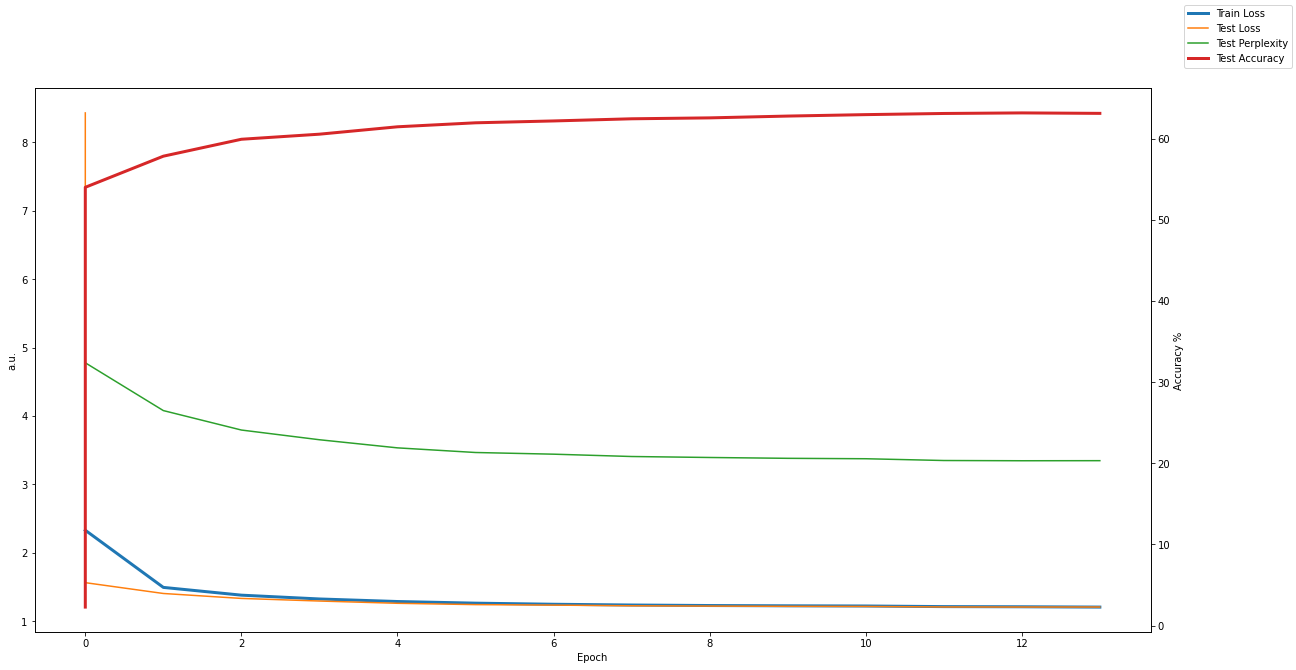

In [72]:

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 13
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 100
    LOG_PATH = DATA_PATH + 'logs/KJV_LSTM_Rev/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'KJV_Bible_reverse_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'KJV_Bible_reverse_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetLSTM(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/KJV_LSTM_Rev')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test_chars_lstm(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train_lstm(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test_chars_lstm(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # add perplexity
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/KJV_LSTM_Rev/%03d.pt' % epoch)
            seed_words = 'The Father, the Son, and the Holy Spirit walk into a bar. '
            seed_words = seed_words[::-1]
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence[::-1])
            for ii in range(10):
                generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence[::-1])
            generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam')
            # generated_sentence = generate_language_chars(model, device, seed_words, 200, vocab, 'beam', beam_width = 20)
            print('generated beam\t\t', generated_sentence[::-1])
            print('\n\n')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/KJV_LSTM_Rev/%03d.pt' % epoch, 0)
        fig, ax1 = plt.subplots(figsize=(20,10))
        ep, val = zip(*train_losses)
        ln1 = ax1.plot(ep, val, label='Train Loss', linewidth=3)
        ep, val = zip(*test_losses)
        ln2 = ax1.plot(ep, val, label='Test Loss')
        ep, val = zip(*test_perplexities)
        ln3 = ax1.plot(ep, val, label='Test Perplexity')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('a.u.')
        ax2 = ax1.twinx()
        ep, val = zip(*test_accuracies)
        ln4 = ax2.plot(ep, val, label='Test Accuracy', linewidth=3, color='tab:red')
        ax2.set_ylabel('Accuracy %')
        fig.legend()
        return model, vocab, device

final_kjv_lstm_rev_model, vocab, device = main()

In [80]:
def eval_final_model(model, vocab, device):
    # seed_words = ' and he saw that it was good.'
    seed_words = '. This is the way.'
    seed_words = seed_words[::-1]
    sequence_length = 150

    generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'max', temperature=1)
    print('generated with max\t', generated_sentence[::-1])

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'sample', temperature=(ii+1)*2/10)
        print('generated with sample\t', generated_sentence[::-1])

    for ii in range(10):
        generated_sentence = generate_language_chars(model, device, seed_words, sequence_length, vocab, 'beam', temperature=(ii+1)*2/10)
        print('generated with beam\t', generated_sentence[::-1])

vocab = HarryPotterDataset(DATA_PATH + 'KJV_Bible_reverse_chars_train.pkl', 100, 256).vocab
eval_final_model(final_kjv_lstm_rev_model, vocab, device)

generated with max	 ll be delivered. 1:16 And Jesus answered, and entered into the house of God. 1:1 And it shall be delivered. 1:16 And Jesus answered, and said unto him. This is the way.
generated with sample	  fathers, and entered into the house of God: and he that is in the nimelies. 1:20 And it shall be delivered. 1:6 And Jesus answered, and said unto him. This is the way.
generated with sample	 ers of the cities shall be delivered. 1:4 And he entered into the house of God, that I have delivered him in the treasures of the God, and he that day. This is the way.
generated with sample	 ngers and in his sons wo his hand, and delivered unto the men. 1:14 And he gathered in Eyrimadam. 8:17 And he made of their fathers into the dead. 6:2. This is the way.
generated with sample	 :3 But he say to the Loord in the word; and the vessels of thy God; there there put us two make in the house of the ment, and have no sight against me. This is the way.
generated with sample	  and cause of a parm

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    